In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import torchmetrics
import time
from tqdm import tqdm
import seaborn as sns


# 1. Генерація набору даних

Створюю унікальний набір даних з 10 ознаками, 1 цільовою змінною для регресії та 150 000 рядками

In [23]:
SEED = 535  # моя кімната в гуртожитку :)

In [24]:
n_samples = 150000
n_features = 10
noise = 0.1 + SEED % 10 * 0.01
X, y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=noise, random_state=SEED)

In [25]:
df = pd.DataFrame(X, columns=[f'X{i}' for i in range(1, n_features+1)])
df['target'] = y

In [26]:
df.head()

X1        X2        X3        X4        X5        X6        X7  \
0  0.362160  0.746986  0.163461  0.669082  0.667448  0.439180  0.342904   
1  0.553151  0.175213  0.126109  0.194551  0.439893  0.424700  0.687688   
2  0.974465  0.659989  0.762933  0.646803  0.529981  0.648560  0.972177   
3  0.538529  0.489400  0.625158  0.251168  0.159692  0.422567  0.519831   
4  0.189080  0.325008  0.022063  0.636466  0.986874  0.125750  0.699336   

         X8        X9       X10     target  
0  0.481054  0.814577  0.533022  19.795852  
1  0.945777  0.546477  0.105162   9.847639  
2  0.638162  0.504651  0.720186  19.384930  
3  0.775871  0.628292  0.101436  10.903766  
4  0.891730  0.613856  0.090445  17.619245

In [27]:
# Виведення інформації про датасет
print(f"Форма датасету: {df.shape}")
print("\nОпис датасету:")
print(df.describe())

Форма датасету: (150000, 11)

Опис датасету:
                 X1             X2             X3             X4  \
count  1.500000e+05  150000.000000  150000.000000  150000.000000   
mean   4.990312e-01       0.500487       0.500235       0.499703   
std    2.885582e-01       0.288910       0.288191       0.288561   
min    8.955816e-07       0.000021       0.000013       0.000017   
25%    2.488578e-01       0.249328       0.250880       0.250223   
50%    4.995047e-01       0.501475       0.501346       0.499337   
75%    7.493115e-01       0.749595       0.749783       0.749734   
max    9.999954e-01       0.999999       0.999989       0.999985   

                  X5             X6             X7            X8  \
count  150000.000000  150000.000000  150000.000000  1.500000e+05   
mean        0.500631       0.499444       0.499898  5.006691e-01   
std         0.288770       0.288266       0.288816  2.895066e-01   
min         0.000007       0.000011       0.000007  4.939830e-07   
25

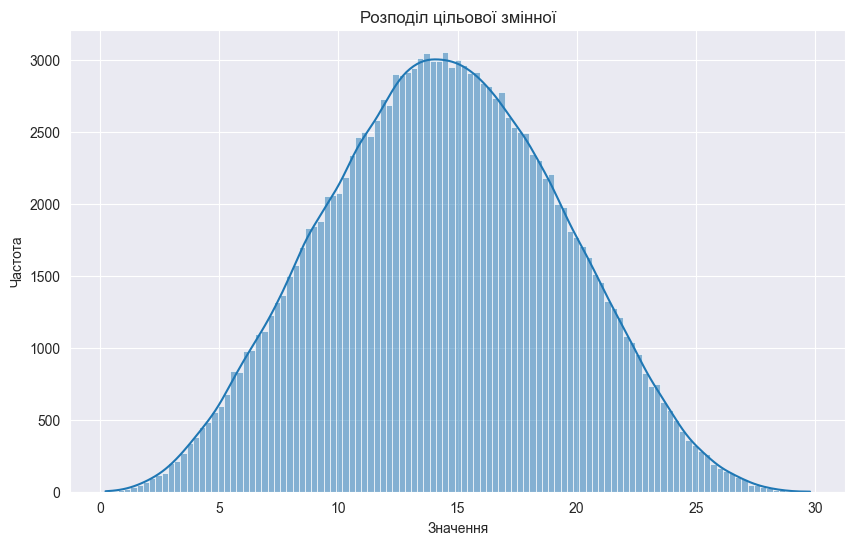

In [28]:
# Візуалізуємо розподіл цільової змінної
plt.figure(figsize=(10, 6))
sns.histplot(df['target'], kde=True)
plt.title('Розподіл цільової змінної')
plt.xlabel('Значення')
plt.ylabel('Частота')
plt.show()

In [29]:
# Розділення даних на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Нормалізація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
print(f"Розмір навчальних даних: {X_train.shape}")
print(f"Розмір тестових даних: {X_test.shape}")

Розмір навчальних даних: (120000, 10)
Розмір тестових даних: (30000, 10)



# 2. Лінійна регресія як базова модель

Спочатку навчимо лінійну регресію як базову модель для порівняння

In [32]:
# Навчання лінійної регресії
lr_model = LinearRegression()
start_time = time.time()
lr_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

In [33]:
# Оцінка моделі
y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)

In [34]:
# Обчислення метрик
lr_train_mse = mean_squared_error(y_train, y_pred_train)
lr_test_mse = mean_squared_error(y_test, y_pred_test)
lr_train_r2 = r2_score(y_train, y_pred_train)
lr_test_r2 = r2_score(y_test, y_pred_test)

In [35]:
# Обчислення MAPE вручну (уникаючи ділення на нуль)
def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

lr_train_mape = calculate_mape(y_train, y_pred_train)
lr_test_mape = calculate_mape(y_test, y_pred_test)

In [36]:
print(f"Час навчання лінійної регресії: {train_time:.2f} секунд")
print(f"Метрики лінійної регресії:")
print(f"  Навчальна вибірка: MSE={lr_train_mse:.4f}, R²={lr_train_r2:.4f}, MAPE={lr_train_mape:.4f}%")
print(f"  Тестова вибірка: MSE={lr_test_mse:.4f}, R²={lr_test_r2:.4f}, MAPE={lr_test_mape:.4f}%")

Час навчання лінійної регресії: 0.03 секунд
Метрики лінійної регресії:
  Навчальна вибірка: MSE=5.9292, R²=0.7524, MAPE=15.5169%
  Тестова вибірка: MSE=5.7626, R²=0.7588, MAPE=15.3049%


In [37]:
# Збереження результатів для подальшого порівняння
lr_results = {
    'model': 'Linear Regression',
    'train_mse': lr_train_mse,
    'test_mse': lr_test_mse,
    'train_r2': lr_train_r2,
    'test_r2': lr_test_r2,
    'train_mape': lr_train_mape,
    'test_mape': lr_test_mape,
    'train_time': train_time
}

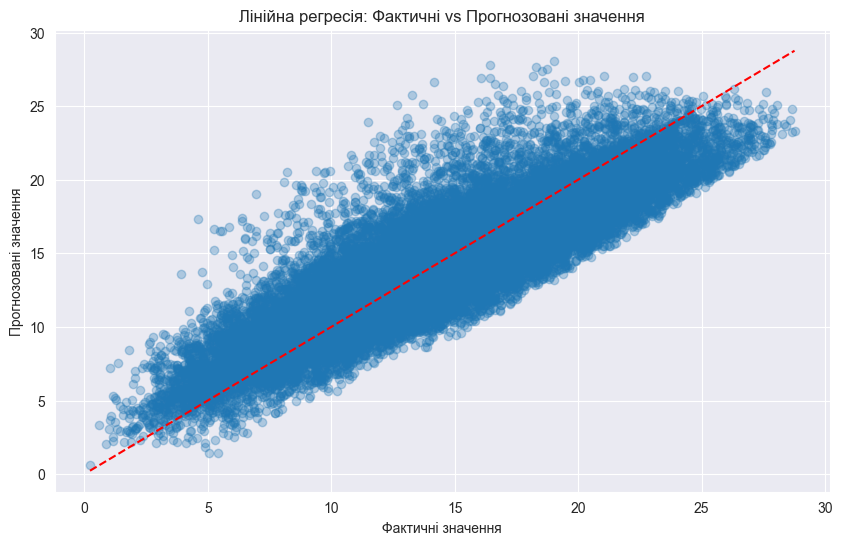

In [38]:
# Візуалізація результатів лінійної регресії
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактичні значення')
plt.ylabel('Прогнозовані значення')
plt.title('Лінійна регресія: Фактичні vs Прогнозовані значення')
plt.show()

# 3. Реалізація нейронних мереж на PyTorch

Тепер створимо клас для нашої нейронної мережі з можливістю налаштування кількості шарів:

In [39]:
# Покращена версія класу нейронної мережі з нормалізацією пакетів
class DNNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_layers=1, neurons_per_layer=64):
        """
        Покращена нейронна мережа з нормалізацією пакетів для стабілізації навчання
        """
        super(DNNRegressor, self).__init__()

        # Вхідний шар
        self.input_layer = nn.Linear(input_dim, neurons_per_layer)
        self.input_bn = nn.BatchNorm1d(neurons_per_layer)

        # Приховані шари з нормалізацією пакетів
        self.hidden_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        for _ in range(hidden_layers):
            self.hidden_layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            self.bn_layers.append(nn.BatchNorm1d(neurons_per_layer))

        # Вихідний шар
        self.output_layer = nn.Linear(neurons_per_layer, 1)

        # Функція активації
        self.activation = nn.ReLU()

        # Покращена ініціалізація ваг для глибоких мереж
        self._init_weights()

    def _init_weights(self):
        """
        Спеціальна ініціалізація ваг для покращення стабільності навчання
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Використовуємо ініціалізацію Ксав'є для лінійних шарів
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Прямий прохід через мережу
        """
        # Вхідний шар
        x = self.input_layer(x)
        x = self.input_bn(x)
        x = self.activation(x)

        # Приховані шари
        for i, (layer, bn) in enumerate(zip(self.hidden_layers, self.bn_layers)):
            x = layer(x)
            x = bn(x)
            x = self.activation(x)

        # Вихідний шар
        return self.output_layer(x).squeeze()

# Покращена функція навчання з обмеженням градієнтів та динамічною швидкістю навчання
def train_model(model, optimizer, criterion, train_loader, test_loader,
               X_train_scaled, y_train, X_test_scaled, y_test,
               epochs=100, device='cpu', clip_value=1.0):
    """
    Тренування моделі з додатковими механізмами стабілізації
    """
    model.to(device)

    # Історія метрик
    history = {
        'train_loss': [], 'test_loss': [],
        'train_r2': [], 'test_r2': [],
        'train_mape': [], 'test_mape': []
    }

    start_time = time.time()

    for epoch in tqdm(range(epochs), desc="Навчання"):
        # Режим навчання
        model.train()
        train_losses = []

        # Навчання на батчах
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обнулення градієнтів
            optimizer.zero_grad()

            # Прямий прохід
            y_pred = model(X_batch)

            # Перевірка на NaN в прогнозах
            if torch.isnan(y_pred).any():
                print(f"Виявлено NaN у прогнозах на епосі {epoch+1}. Пропускаємо цей батч.")
                continue

            # Обчислення втрат
            loss = criterion(y_pred, y_batch)

            # Перевірка на NaN у втратах
            if torch.isnan(loss).any():
                print(f"Виявлено NaN у втратах на епосі {epoch+1}. Пропускаємо цей батч.")
                continue

            # Зворотне поширення помилки
            loss.backward()

            # Обмеження градієнтів для запобігання вибуху
            if clip_value > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # Оновлення вагів
            optimizer.step()

            # Перевірка на NaN в параметрах моделі
            has_nan = False
            for param in model.parameters():
                if torch.isnan(param).any():
                    has_nan = True
                    break

            if has_nan:
                print(f"Виявлено NaN у параметрах моделі на епосі {epoch+1}. Пропускаємо цей батч.")
                continue

            train_losses.append(loss.item())

        # Режим оцінки
        model.eval()
        try:
            with torch.no_grad():
                # Підготовка даних
                X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
                X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

                # Отримання прогнозів
                y_train_pred = model(X_train_tensor).cpu().numpy()
                y_test_pred = model(X_test_tensor).cpu().numpy()

                # Перевірка на NaN у результатах
                if np.isnan(y_train_pred).any() or np.isnan(y_test_pred).any():
                    print(f"Виявлено NaN в оцінці метрик на епосі {epoch+1}.")
                    # Використовуємо дані з попередньої успішної епохи або нулі
                    if epoch > 0:
                        history['train_loss'].append(history['train_loss'][-1])
                        history['test_loss'].append(history['test_loss'][-1])
                        history['train_r2'].append(history['train_r2'][-1])
                        history['test_r2'].append(history['test_r2'][-1])
                        history['train_mape'].append(history['train_mape'][-1])
                        history['test_mape'].append(history['test_mape'][-1])
                    else:
                        history['train_loss'].append(0.0)
                        history['test_loss'].append(0.0)
                        history['train_r2'].append(0.0)
                        history['test_r2'].append(0.0)
                        history['train_mape'].append(0.0)
                        history['test_mape'].append(0.0)
                    continue

                # Обчислення метрик
                train_mse = mean_squared_error(y_train, y_train_pred)
                test_mse = mean_squared_error(y_test, y_test_pred)
                train_r2 = r2_score(y_train, y_train_pred)
                test_r2 = r2_score(y_test, y_test_pred)

                # Функція для обчислення MAPE (з обробкою випадку ділення на нуль)
                def calculate_mape(y_true, y_pred):
                    mask = y_true != 0
                    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

                train_mape = calculate_mape(y_train, y_train_pred)
                test_mape = calculate_mape(y_test, y_test_pred)

                # Зберігаємо метрики
                history['train_loss'].append(train_mse)
                history['test_loss'].append(test_mse)
                history['train_r2'].append(train_r2)
                history['test_r2'].append(test_r2)
                history['train_mape'].append(train_mape)
                history['test_mape'].append(test_mape)

                # Виведення проміжних результатів
                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f"Епоха {epoch+1}/{epochs}: "
                          f"MSE_train={train_mse:.4f}, MSE_test={test_mse:.4f}, "
                          f"R²_train={train_r2:.4f}, R²_test={test_r2:.4f}")
        except Exception as e:
            print(f"Помилка при оцінці метрик на епосі {epoch+1}: {str(e)}")
            if epoch > 0:
                history['train_loss'].append(history['train_loss'][-1])
                history['test_loss'].append(history['test_loss'][-1])
                history['train_r2'].append(history['train_r2'][-1])
                history['test_r2'].append(history['test_r2'][-1])
                history['train_mape'].append(history['train_mape'][-1])
                history['test_mape'].append(history['test_mape'][-1])
            else:
                history['train_loss'].append(0.0)
                history['test_loss'].append(0.0)
                history['train_r2'].append(0.0)
                history['test_r2'].append(0.0)
                history['train_mape'].append(0.0)
                history['test_mape'].append(0.0)

    # Час навчання
    train_time = time.time() - start_time
    history['train_time'] = train_time

    return history

# 4. Тренування всіх комбінацій моделей глибокого навчання

Тепер створимо функцію, яка буде навчати всі 27 комбінацій моделей з різними параметрами:

In [40]:
# Підготовка даних для PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Створення об'єктів DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Параметри для експериментів
hidden_layers_options = [1, 5, 25]
optimizer_options = ['SGD', 'RMSprop', 'Adam']
learning_rate_options = [0.1, 0.01, 0.001]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Використовується пристрій: {device}")

epochs = 100  # Кількість епох для тренування кожної моделі
input_dim = X_train.shape[1]  # Кількість вхідних ознак
neurons_per_layer = 64  # Кількість нейронів у кожному шарі

results = []
histories = {}

Використовується пристрій: cuda


In [41]:
# Основний цикл для тренування всіх комбінацій моделей
for n_layers in hidden_layers_options:
    for optim_name in optimizer_options:
        for lr in learning_rate_options:
            # Формування унікальної назви моделі
            model_name = f"DNN_{n_layers}_layers_{optim_name}_lr_{lr}"
            print(f"\nНавчання моделі: {model_name}")

            # Створення моделі
            model = DNNRegressor(input_dim, hidden_layers=n_layers, neurons_per_layer=neurons_per_layer)

            # Вибір оптимізатора
            if optim_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif optim_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            else:  # Adam
                optimizer = optim.Adam(model.parameters(), lr=lr)

            # Функція втрат
            criterion = nn.MSELoss()

            # Тренування моделі та отримання історії метрик
            history = train_model(
                model, optimizer, criterion, train_loader, test_loader,
                X_train_scaled, y_train, X_test_scaled, y_test,
                epochs=epochs, device=device
            )

            # Збереження історії
            histories[model_name] = history

            # Збереження фінальних метрик
            result = {
                'model': model_name,
                'layers': n_layers,
                'optimizer': optim_name,
                'learning_rate': lr,
                'train_mse': history['train_loss'][-1],
                'test_mse': history['test_loss'][-1],
                'train_r2': history['train_r2'][-1],
                'test_r2': history['test_r2'][-1],
                'train_mape': history['train_mape'][-1],
                'test_mape': history['test_mape'][-1],
                'train_time': history['train_time']
            }
            results.append(result)

            # Виведення результатів
            print(f"Час навчання: {history['train_time']:.2f} секунд")
            print(f"Метрики:")
            print(f"  Навчальна вибірка: MSE={result['train_mse']:.4f}, R²={result['train_r2']:.4f}, MAPE={result['train_mape']:.4f}%")
            print(f"  Тестова вибірка: MSE={result['test_mse']:.4f}, R²={result['test_r2']:.4f}, MAPE={result['test_mape']:.4f}%")


Навчання моделі: DNN_1_layers_SGD_lr_0.1


Навчання:   1%|          | 1/100 [00:01<02:54,  1.76s/it]

Епоха 1/100: MSE_train=1.3652, MSE_test=1.3614, R²_train=0.9430, R²_test=0.9430


Навчання:  11%|█         | 11/100 [00:16<02:23,  1.61s/it]

Епоха 11/100: MSE_train=0.5079, MSE_test=0.5078, R²_train=0.9788, R²_test=0.9787


Навчання:  21%|██        | 21/100 [00:32<01:57,  1.49s/it]

Епоха 21/100: MSE_train=0.2008, MSE_test=0.2011, R²_train=0.9916, R²_test=0.9916


Навчання:  31%|███       | 31/100 [00:47<01:37,  1.41s/it]

Епоха 31/100: MSE_train=0.2984, MSE_test=0.2981, R²_train=0.9875, R²_test=0.9875


Навчання:  41%|████      | 41/100 [01:01<01:20,  1.36s/it]

Епоха 41/100: MSE_train=0.4934, MSE_test=0.4937, R²_train=0.9794, R²_test=0.9793


Навчання:  51%|█████     | 51/100 [01:17<01:20,  1.63s/it]

Епоха 51/100: MSE_train=0.2072, MSE_test=0.2067, R²_train=0.9913, R²_test=0.9913


Навчання:  61%|██████    | 61/100 [01:31<00:57,  1.48s/it]

Епоха 61/100: MSE_train=0.2806, MSE_test=0.2827, R²_train=0.9883, R²_test=0.9882


Навчання:  71%|███████   | 71/100 [01:46<00:42,  1.48s/it]

Епоха 71/100: MSE_train=0.3093, MSE_test=0.3081, R²_train=0.9871, R²_test=0.9871


Навчання:  81%|████████  | 81/100 [02:01<00:31,  1.64s/it]

Епоха 81/100: MSE_train=0.0852, MSE_test=0.0855, R²_train=0.9964, R²_test=0.9964


Навчання:  91%|█████████ | 91/100 [02:19<00:15,  1.69s/it]

Епоха 91/100: MSE_train=0.0465, MSE_test=0.0471, R²_train=0.9981, R²_test=0.9980


Навчання: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Епоха 100/100: MSE_train=0.0630, MSE_test=0.0638, R²_train=0.9974, R²_test=0.9973
Час навчання: 156.25 секунд
Метрики:
  Навчальна вибірка: MSE=0.0630, R²=0.9974, MAPE=1.5696%
  Тестова вибірка: MSE=0.0638, R²=0.9973, MAPE=1.5869%

Навчання моделі: DNN_1_layers_SGD_lr_0.01


Навчання:   1%|          | 1/100 [00:01<02:48,  1.70s/it]

Епоха 1/100: MSE_train=128.5681, MSE_test=128.0607, R²_train=-4.3688, R²_test=-4.3607


Навчання:  11%|█         | 11/100 [00:19<02:32,  1.72s/it]

Епоха 11/100: MSE_train=0.8324, MSE_test=0.8341, R²_train=0.9652, R²_test=0.9651


Навчання:  21%|██        | 21/100 [00:37<02:15,  1.71s/it]

Епоха 21/100: MSE_train=0.4833, MSE_test=0.4875, R²_train=0.9798, R²_test=0.9796


Навчання:  31%|███       | 31/100 [00:54<01:53,  1.64s/it]

Епоха 31/100: MSE_train=0.2879, MSE_test=0.2908, R²_train=0.9880, R²_test=0.9878


Навчання:  41%|████      | 41/100 [01:11<01:37,  1.65s/it]

Епоха 41/100: MSE_train=0.2119, MSE_test=0.2138, R²_train=0.9912, R²_test=0.9910


Навчання:  51%|█████     | 51/100 [01:25<01:11,  1.45s/it]

Епоха 51/100: MSE_train=0.1616, MSE_test=0.1635, R²_train=0.9933, R²_test=0.9932


Навчання:  61%|██████    | 61/100 [01:39<00:55,  1.42s/it]

Епоха 61/100: MSE_train=0.1300, MSE_test=0.1322, R²_train=0.9946, R²_test=0.9945


Навчання:  71%|███████   | 71/100 [01:52<00:39,  1.36s/it]

Епоха 71/100: MSE_train=0.1166, MSE_test=0.1187, R²_train=0.9951, R²_test=0.9950


Навчання:  81%|████████  | 81/100 [02:06<00:26,  1.40s/it]

Епоха 81/100: MSE_train=0.0992, MSE_test=0.1012, R²_train=0.9959, R²_test=0.9958


Навчання:  91%|█████████ | 91/100 [02:21<00:12,  1.39s/it]

Епоха 91/100: MSE_train=0.0928, MSE_test=0.0944, R²_train=0.9961, R²_test=0.9960


Навчання: 100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


Епоха 100/100: MSE_train=0.0847, MSE_test=0.0867, R²_train=0.9965, R²_test=0.9964
Час навчання: 153.70 секунд
Метрики:
  Навчальна вибірка: MSE=0.0847, R²=0.9965, MAPE=1.9161%
  Тестова вибірка: MSE=0.0867, R²=0.9964, MAPE=1.9378%

Навчання моделі: DNN_1_layers_SGD_lr_0.001


Навчання:   1%|          | 1/100 [00:01<02:14,  1.35s/it]

Епоха 1/100: MSE_train=216.2883, MSE_test=215.2676, R²_train=-8.0319, R²_test=-8.0112


Навчання:  11%|█         | 11/100 [00:15<02:03,  1.39s/it]

Епоха 11/100: MSE_train=116.5881, MSE_test=116.0834, R²_train=-3.8686, R²_test=-3.8593


Навчання:  21%|██        | 21/100 [00:28<01:45,  1.33s/it]

Епоха 21/100: MSE_train=42.6435, MSE_test=42.5091, R²_train=-0.7807, R²_test=-0.7795


Навчання:  31%|███       | 31/100 [00:42<01:35,  1.39s/it]

Епоха 31/100: MSE_train=7.0670, MSE_test=6.9959, R²_train=0.7049, R²_test=0.7071


Навчання:  41%|████      | 41/100 [00:57<01:26,  1.47s/it]

Епоха 41/100: MSE_train=2.8111, MSE_test=2.7887, R²_train=0.8826, R²_test=0.8833


Навчання:  51%|█████     | 51/100 [01:10<01:05,  1.35s/it]

Епоха 51/100: MSE_train=1.7931, MSE_test=1.7806, R²_train=0.9251, R²_test=0.9255


Навчання:  61%|██████    | 61/100 [01:24<00:55,  1.43s/it]

Епоха 61/100: MSE_train=1.3937, MSE_test=1.3779, R²_train=0.9418, R²_test=0.9423


Навчання:  71%|███████   | 71/100 [01:39<00:41,  1.42s/it]

Епоха 71/100: MSE_train=1.2113, MSE_test=1.2019, R²_train=0.9494, R²_test=0.9497


Навчання:  81%|████████  | 81/100 [01:53<00:28,  1.49s/it]

Епоха 81/100: MSE_train=1.1028, MSE_test=1.0959, R²_train=0.9539, R²_test=0.9541


Навчання:  91%|█████████ | 91/100 [02:08<00:14,  1.63s/it]

Епоха 91/100: MSE_train=0.9994, MSE_test=0.9908, R²_train=0.9583, R²_test=0.9585


Навчання: 100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


Епоха 100/100: MSE_train=0.9345, MSE_test=0.9252, R²_train=0.9610, R²_test=0.9613
Час навчання: 142.82 секунд
Метрики:
  Навчальна вибірка: MSE=0.9345, R²=0.9610, MAPE=6.2350%
  Тестова вибірка: MSE=0.9252, R²=0.9613, MAPE=6.2725%

Навчання моделі: DNN_1_layers_RMSprop_lr_0.1


Навчання:   1%|          | 1/100 [00:01<02:22,  1.44s/it]

Епоха 1/100: MSE_train=3.6132, MSE_test=3.6195, R²_train=0.8491, R²_test=0.8485


Навчання:  11%|█         | 11/100 [00:15<02:05,  1.41s/it]

Епоха 11/100: MSE_train=0.3245, MSE_test=0.3259, R²_train=0.9864, R²_test=0.9864


Навчання:  21%|██        | 21/100 [00:30<01:53,  1.44s/it]

Епоха 21/100: MSE_train=1.1359, MSE_test=1.1418, R²_train=0.9526, R²_test=0.9522


Навчання:  31%|███       | 31/100 [00:44<01:37,  1.42s/it]

Епоха 31/100: MSE_train=0.7507, MSE_test=0.7458, R²_train=0.9687, R²_test=0.9688


Навчання:  41%|████      | 41/100 [00:59<01:25,  1.44s/it]

Епоха 41/100: MSE_train=1.0608, MSE_test=1.0624, R²_train=0.9557, R²_test=0.9555


Навчання:  51%|█████     | 51/100 [01:13<01:08,  1.40s/it]

Епоха 51/100: MSE_train=0.3947, MSE_test=0.3948, R²_train=0.9835, R²_test=0.9835


Навчання:  61%|██████    | 61/100 [01:27<00:56,  1.46s/it]

Епоха 61/100: MSE_train=0.3062, MSE_test=0.2991, R²_train=0.9872, R²_test=0.9875


Навчання:  71%|███████   | 71/100 [01:42<00:44,  1.54s/it]

Епоха 71/100: MSE_train=0.7196, MSE_test=0.7268, R²_train=0.9700, R²_test=0.9696


Навчання:  81%|████████  | 81/100 [01:57<00:26,  1.41s/it]

Епоха 81/100: MSE_train=0.3079, MSE_test=0.2984, R²_train=0.9871, R²_test=0.9875


Навчання:  91%|█████████ | 91/100 [02:11<00:13,  1.47s/it]

Епоха 91/100: MSE_train=0.2842, MSE_test=0.2864, R²_train=0.9881, R²_test=0.9880


Навчання: 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


Епоха 100/100: MSE_train=0.8288, MSE_test=0.8229, R²_train=0.9654, R²_test=0.9656
Час навчання: 144.19 секунд
Метрики:
  Навчальна вибірка: MSE=0.8288, R²=0.9654, MAPE=6.6609%
  Тестова вибірка: MSE=0.8229, R²=0.9656, MAPE=6.6830%

Навчання моделі: DNN_1_layers_RMSprop_lr_0.01


Навчання:   1%|          | 1/100 [00:01<02:09,  1.31s/it]

Епоха 1/100: MSE_train=0.7388, MSE_test=0.7400, R²_train=0.9692, R²_test=0.9690


Навчання:  11%|█         | 11/100 [00:15<02:04,  1.40s/it]

Епоха 11/100: MSE_train=0.1100, MSE_test=0.1097, R²_train=0.9954, R²_test=0.9954


Навчання:  21%|██        | 21/100 [00:30<01:53,  1.43s/it]

Епоха 21/100: MSE_train=0.0779, MSE_test=0.0777, R²_train=0.9967, R²_test=0.9967


Навчання:  31%|███       | 31/100 [00:44<01:36,  1.40s/it]

Епоха 31/100: MSE_train=0.2628, MSE_test=0.2629, R²_train=0.9890, R²_test=0.9890


Навчання:  41%|████      | 41/100 [00:59<01:27,  1.48s/it]

Епоха 41/100: MSE_train=0.0741, MSE_test=0.0743, R²_train=0.9969, R²_test=0.9969


Навчання:  51%|█████     | 51/100 [01:14<01:10,  1.45s/it]

Епоха 51/100: MSE_train=0.0949, MSE_test=0.0962, R²_train=0.9960, R²_test=0.9960


Навчання:  61%|██████    | 61/100 [01:28<00:56,  1.44s/it]

Епоха 61/100: MSE_train=0.1467, MSE_test=0.1460, R²_train=0.9939, R²_test=0.9939


Навчання:  71%|███████   | 71/100 [01:44<00:46,  1.61s/it]

Епоха 71/100: MSE_train=0.0594, MSE_test=0.0593, R²_train=0.9975, R²_test=0.9975


Навчання:  81%|████████  | 81/100 [01:59<00:26,  1.41s/it]

Епоха 81/100: MSE_train=0.1101, MSE_test=0.1104, R²_train=0.9954, R²_test=0.9954


Навчання:  91%|█████████ | 91/100 [02:13<00:12,  1.43s/it]

Епоха 91/100: MSE_train=0.1591, MSE_test=0.1574, R²_train=0.9934, R²_test=0.9934


Навчання: 100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Епоха 100/100: MSE_train=0.1519, MSE_test=0.1504, R²_train=0.9937, R²_test=0.9937
Час навчання: 146.42 секунд
Метрики:
  Навчальна вибірка: MSE=0.1519, R²=0.9937, MAPE=2.3158%
  Тестова вибірка: MSE=0.1504, R²=0.9937, MAPE=2.3170%

Навчання моделі: DNN_1_layers_RMSprop_lr_0.001


Навчання:   1%|          | 1/100 [00:01<01:59,  1.21s/it]

Епоха 1/100: MSE_train=35.3325, MSE_test=35.4569, R²_train=-0.4754, R²_test=-0.4842


Навчання:  11%|█         | 11/100 [00:15<02:05,  1.41s/it]

Епоха 11/100: MSE_train=0.1476, MSE_test=0.1483, R²_train=0.9938, R²_test=0.9938


Навчання:  21%|██        | 21/100 [00:29<01:48,  1.38s/it]

Епоха 21/100: MSE_train=0.1239, MSE_test=0.1238, R²_train=0.9948, R²_test=0.9948


Навчання:  31%|███       | 31/100 [00:42<01:33,  1.35s/it]

Епоха 31/100: MSE_train=0.1212, MSE_test=0.1208, R²_train=0.9949, R²_test=0.9949


Навчання:  41%|████      | 41/100 [00:56<01:21,  1.37s/it]

Епоха 41/100: MSE_train=0.0991, MSE_test=0.1002, R²_train=0.9959, R²_test=0.9958


Навчання:  51%|█████     | 51/100 [01:10<01:10,  1.44s/it]

Епоха 51/100: MSE_train=0.0505, MSE_test=0.0515, R²_train=0.9979, R²_test=0.9978


Навчання:  61%|██████    | 61/100 [01:24<00:53,  1.38s/it]

Епоха 61/100: MSE_train=0.0761, MSE_test=0.0763, R²_train=0.9968, R²_test=0.9968


Навчання:  71%|███████   | 71/100 [01:38<00:41,  1.43s/it]

Епоха 71/100: MSE_train=0.0763, MSE_test=0.0751, R²_train=0.9968, R²_test=0.9969


Навчання:  81%|████████  | 81/100 [01:53<00:28,  1.47s/it]

Епоха 81/100: MSE_train=0.0411, MSE_test=0.0421, R²_train=0.9983, R²_test=0.9982


Навчання:  91%|█████████ | 91/100 [02:08<00:13,  1.50s/it]

Епоха 91/100: MSE_train=0.0567, MSE_test=0.0568, R²_train=0.9976, R²_test=0.9976


Навчання: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


Епоха 100/100: MSE_train=0.0596, MSE_test=0.0601, R²_train=0.9975, R²_test=0.9975
Час навчання: 141.51 секунд
Метрики:
  Навчальна вибірка: MSE=0.0596, R²=0.9975, MAPE=1.4918%
  Тестова вибірка: MSE=0.0601, R²=0.9975, MAPE=1.5004%

Навчання моделі: DNN_1_layers_Adam_lr_0.1


Навчання:   1%|          | 1/100 [00:01<02:38,  1.60s/it]

Епоха 1/100: MSE_train=0.5932, MSE_test=0.5912, R²_train=0.9752, R²_test=0.9753


Навчання:  11%|█         | 11/100 [00:15<02:06,  1.42s/it]

Епоха 11/100: MSE_train=0.2888, MSE_test=0.2853, R²_train=0.9879, R²_test=0.9881


Навчання:  21%|██        | 21/100 [00:30<01:52,  1.42s/it]

Епоха 21/100: MSE_train=0.5352, MSE_test=0.5332, R²_train=0.9777, R²_test=0.9777


Навчання:  31%|███       | 31/100 [00:44<01:38,  1.43s/it]

Епоха 31/100: MSE_train=0.1286, MSE_test=0.1288, R²_train=0.9946, R²_test=0.9946


Навчання:  41%|████      | 41/100 [00:59<01:29,  1.52s/it]

Епоха 41/100: MSE_train=0.1302, MSE_test=0.1297, R²_train=0.9946, R²_test=0.9946


Навчання:  51%|█████     | 51/100 [01:13<01:11,  1.47s/it]

Епоха 51/100: MSE_train=0.1120, MSE_test=0.1124, R²_train=0.9953, R²_test=0.9953


Навчання:  61%|██████    | 61/100 [01:29<00:59,  1.52s/it]

Епоха 61/100: MSE_train=0.0565, MSE_test=0.0570, R²_train=0.9976, R²_test=0.9976


Навчання:  71%|███████   | 71/100 [01:44<00:44,  1.52s/it]

Епоха 71/100: MSE_train=0.0514, MSE_test=0.0521, R²_train=0.9979, R²_test=0.9978


Навчання:  81%|████████  | 81/100 [01:59<00:28,  1.48s/it]

Епоха 81/100: MSE_train=0.0988, MSE_test=0.0994, R²_train=0.9959, R²_test=0.9958


Навчання:  91%|█████████ | 91/100 [02:14<00:13,  1.46s/it]

Епоха 91/100: MSE_train=0.1138, MSE_test=0.1138, R²_train=0.9952, R²_test=0.9952


Навчання: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Епоха 100/100: MSE_train=0.1447, MSE_test=0.1442, R²_train=0.9940, R²_test=0.9940
Час навчання: 147.64 секунд
Метрики:
  Навчальна вибірка: MSE=0.1447, R²=0.9940, MAPE=2.4271%
  Тестова вибірка: MSE=0.1442, R²=0.9940, MAPE=2.4692%

Навчання моделі: DNN_1_layers_Adam_lr_0.01


Навчання:   1%|          | 1/100 [00:01<02:17,  1.39s/it]

Епоха 1/100: MSE_train=0.7020, MSE_test=0.7086, R²_train=0.9707, R²_test=0.9703


Навчання:  11%|█         | 11/100 [00:16<02:12,  1.49s/it]

Епоха 11/100: MSE_train=0.1580, MSE_test=0.1568, R²_train=0.9934, R²_test=0.9934


Навчання:  21%|██        | 21/100 [00:31<01:52,  1.43s/it]

Епоха 21/100: MSE_train=0.2259, MSE_test=0.2258, R²_train=0.9906, R²_test=0.9905


Навчання:  31%|███       | 31/100 [00:46<01:46,  1.54s/it]

Епоха 31/100: MSE_train=0.1289, MSE_test=0.1301, R²_train=0.9946, R²_test=0.9946


Навчання:  41%|████      | 41/100 [01:01<01:27,  1.48s/it]

Епоха 41/100: MSE_train=0.0557, MSE_test=0.0555, R²_train=0.9977, R²_test=0.9977


Навчання:  51%|█████     | 51/100 [01:15<01:11,  1.46s/it]

Епоха 51/100: MSE_train=0.1755, MSE_test=0.1754, R²_train=0.9927, R²_test=0.9927


Навчання:  61%|██████    | 61/100 [01:30<00:57,  1.46s/it]

Епоха 61/100: MSE_train=0.0601, MSE_test=0.0606, R²_train=0.9975, R²_test=0.9975


Навчання:  71%|███████   | 71/100 [01:44<00:41,  1.43s/it]

Епоха 71/100: MSE_train=0.0732, MSE_test=0.0734, R²_train=0.9969, R²_test=0.9969


Навчання:  81%|████████  | 81/100 [01:59<00:28,  1.52s/it]

Епоха 81/100: MSE_train=0.1054, MSE_test=0.1051, R²_train=0.9956, R²_test=0.9956


Навчання:  91%|█████████ | 91/100 [02:14<00:13,  1.46s/it]

Епоха 91/100: MSE_train=0.0466, MSE_test=0.0467, R²_train=0.9981, R²_test=0.9980


Навчання: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Епоха 100/100: MSE_train=0.0748, MSE_test=0.0749, R²_train=0.9969, R²_test=0.9969
Час навчання: 146.72 секунд
Метрики:
  Навчальна вибірка: MSE=0.0748, R²=0.9969, MAPE=1.6138%
  Тестова вибірка: MSE=0.0749, R²=0.9969, MAPE=1.6294%

Навчання моделі: DNN_1_layers_Adam_lr_0.001


Навчання:   1%|          | 1/100 [00:01<02:22,  1.44s/it]

Епоха 1/100: MSE_train=98.8044, MSE_test=98.7196, R²_train=-3.1259, R²_test=-3.1325


Навчання:  11%|█         | 11/100 [00:15<02:04,  1.40s/it]

Епоха 11/100: MSE_train=0.1647, MSE_test=0.1668, R²_train=0.9931, R²_test=0.9930


Навчання:  21%|██        | 21/100 [00:29<01:48,  1.38s/it]

Епоха 21/100: MSE_train=0.0811, MSE_test=0.0828, R²_train=0.9966, R²_test=0.9965


Навчання:  31%|███       | 31/100 [00:42<01:33,  1.35s/it]

Епоха 31/100: MSE_train=0.0661, MSE_test=0.0675, R²_train=0.9972, R²_test=0.9972


Навчання:  41%|████      | 41/100 [00:56<01:16,  1.30s/it]

Епоха 41/100: MSE_train=0.0663, MSE_test=0.0675, R²_train=0.9972, R²_test=0.9972


Навчання:  51%|█████     | 51/100 [01:11<01:16,  1.57s/it]

Епоха 51/100: MSE_train=0.0694, MSE_test=0.0713, R²_train=0.9971, R²_test=0.9970


Навчання:  61%|██████    | 61/100 [01:25<00:57,  1.48s/it]

Епоха 61/100: MSE_train=0.0594, MSE_test=0.0610, R²_train=0.9975, R²_test=0.9974


Навчання:  71%|███████   | 71/100 [01:40<00:43,  1.50s/it]

Епоха 71/100: MSE_train=0.0472, MSE_test=0.0486, R²_train=0.9980, R²_test=0.9980


Навчання:  81%|████████  | 81/100 [01:55<00:27,  1.45s/it]

Епоха 81/100: MSE_train=0.0761, MSE_test=0.0773, R²_train=0.9968, R²_test=0.9968


Навчання:  91%|█████████ | 91/100 [02:09<00:12,  1.42s/it]

Епоха 91/100: MSE_train=0.0544, MSE_test=0.0556, R²_train=0.9977, R²_test=0.9977


Навчання: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


Епоха 100/100: MSE_train=0.0601, MSE_test=0.0614, R²_train=0.9975, R²_test=0.9974
Час навчання: 142.47 секунд
Метрики:
  Навчальна вибірка: MSE=0.0601, R²=0.9975, MAPE=1.5618%
  Тестова вибірка: MSE=0.0614, R²=0.9974, MAPE=1.5994%

Навчання моделі: DNN_5_layers_SGD_lr_0.1


Навчання:   1%|          | 1/100 [00:01<03:04,  1.87s/it]

Епоха 1/100: MSE_train=1.5087, MSE_test=1.5421, R²_train=0.9370, R²_test=0.9354


Навчання:  11%|█         | 11/100 [00:19<02:38,  1.79s/it]

Епоха 11/100: MSE_train=0.2833, MSE_test=0.2894, R²_train=0.9882, R²_test=0.9879


Навчання:  21%|██        | 21/100 [00:38<02:23,  1.82s/it]

Епоха 21/100: MSE_train=0.2875, MSE_test=0.2889, R²_train=0.9880, R²_test=0.9879


Навчання:  31%|███       | 31/100 [00:56<02:06,  1.83s/it]

Епоха 31/100: MSE_train=0.1638, MSE_test=0.1644, R²_train=0.9932, R²_test=0.9931


Навчання:  41%|████      | 41/100 [01:14<01:46,  1.81s/it]

Епоха 41/100: MSE_train=0.1468, MSE_test=0.1484, R²_train=0.9939, R²_test=0.9938


Навчання:  51%|█████     | 51/100 [01:32<01:30,  1.84s/it]

Епоха 51/100: MSE_train=0.1288, MSE_test=0.1308, R²_train=0.9946, R²_test=0.9945


Навчання:  61%|██████    | 61/100 [01:50<01:08,  1.77s/it]

Епоха 61/100: MSE_train=0.0803, MSE_test=0.0808, R²_train=0.9966, R²_test=0.9966


Навчання:  71%|███████   | 71/100 [02:08<00:51,  1.78s/it]

Епоха 71/100: MSE_train=0.0648, MSE_test=0.0651, R²_train=0.9973, R²_test=0.9973


Навчання:  81%|████████  | 81/100 [02:26<00:32,  1.73s/it]

Епоха 81/100: MSE_train=0.1131, MSE_test=0.1155, R²_train=0.9953, R²_test=0.9952


Навчання:  91%|█████████ | 91/100 [02:44<00:16,  1.86s/it]

Епоха 91/100: MSE_train=0.3333, MSE_test=0.3314, R²_train=0.9861, R²_test=0.9861


Навчання: 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


Епоха 100/100: MSE_train=0.0799, MSE_test=0.0814, R²_train=0.9967, R²_test=0.9966
Час навчання: 180.44 секунд
Метрики:
  Навчальна вибірка: MSE=0.0799, R²=0.9967, MAPE=1.8161%
  Тестова вибірка: MSE=0.0814, R²=0.9966, MAPE=1.8492%

Навчання моделі: DNN_5_layers_SGD_lr_0.01


Навчання:   1%|          | 1/100 [00:01<03:15,  1.98s/it]

Епоха 1/100: MSE_train=137.0077, MSE_test=136.3519, R²_train=-4.7213, R²_test=-4.7078


Навчання:  11%|█         | 11/100 [00:20<02:45,  1.85s/it]

Епоха 11/100: MSE_train=0.7264, MSE_test=0.7737, R²_train=0.9697, R²_test=0.9676


Навчання:  21%|██        | 21/100 [00:38<02:30,  1.90s/it]

Епоха 21/100: MSE_train=0.2764, MSE_test=0.2953, R²_train=0.9885, R²_test=0.9876


Навчання:  31%|███       | 31/100 [00:56<02:04,  1.80s/it]

Епоха 31/100: MSE_train=0.1784, MSE_test=0.1891, R²_train=0.9926, R²_test=0.9921


Навчання:  41%|████      | 41/100 [01:14<01:45,  1.78s/it]

Епоха 41/100: MSE_train=0.1371, MSE_test=0.1453, R²_train=0.9943, R²_test=0.9939


Навчання:  51%|█████     | 51/100 [01:33<01:29,  1.83s/it]

Епоха 51/100: MSE_train=0.1195, MSE_test=0.1256, R²_train=0.9950, R²_test=0.9947


Навчання:  61%|██████    | 61/100 [01:51<01:08,  1.76s/it]

Епоха 61/100: MSE_train=0.0983, MSE_test=0.1027, R²_train=0.9959, R²_test=0.9957


Навчання:  71%|███████   | 71/100 [02:09<00:54,  1.86s/it]

Епоха 71/100: MSE_train=0.1000, MSE_test=0.1034, R²_train=0.9958, R²_test=0.9957


Навчання:  81%|████████  | 81/100 [02:27<00:34,  1.83s/it]

Епоха 81/100: MSE_train=0.0751, MSE_test=0.0789, R²_train=0.9969, R²_test=0.9967


Навчання:  91%|█████████ | 91/100 [02:46<00:16,  1.88s/it]

Епоха 91/100: MSE_train=0.0714, MSE_test=0.0746, R²_train=0.9970, R²_test=0.9969


Навчання: 100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


Епоха 100/100: MSE_train=0.0668, MSE_test=0.0700, R²_train=0.9972, R²_test=0.9971
Час навчання: 182.81 секунд
Метрики:
  Навчальна вибірка: MSE=0.0668, R²=0.9972, MAPE=1.7174%
  Тестова вибірка: MSE=0.0700, R²=0.9971, MAPE=1.7781%

Навчання моделі: DNN_5_layers_SGD_lr_0.001


Навчання:   1%|          | 1/100 [00:01<03:03,  1.85s/it]

Епоха 1/100: MSE_train=203.6062, MSE_test=202.7229, R²_train=-7.5023, R²_test=-7.4861


Навчання:  11%|█         | 11/100 [00:19<02:38,  1.79s/it]

Епоха 11/100: MSE_train=109.5932, MSE_test=109.1954, R²_train=-3.5765, R²_test=-3.5710


Навчання:  21%|██        | 21/100 [00:38<02:23,  1.82s/it]

Епоха 21/100: MSE_train=41.0108, MSE_test=41.1071, R²_train=-0.7126, R²_test=-0.7208


Навчання:  31%|███       | 31/100 [00:56<02:00,  1.74s/it]

Епоха 31/100: MSE_train=8.9320, MSE_test=8.9648, R²_train=0.6270, R²_test=0.6247


Навчання:  41%|████      | 41/100 [01:14<01:46,  1.80s/it]

Епоха 41/100: MSE_train=4.0654, MSE_test=4.1151, R²_train=0.8302, R²_test=0.8277


Навчання:  51%|█████     | 51/100 [01:32<01:26,  1.77s/it]

Епоха 51/100: MSE_train=2.6703, MSE_test=2.7220, R²_train=0.8885, R²_test=0.8861


Навчання:  61%|██████    | 61/100 [01:50<01:12,  1.86s/it]

Епоха 61/100: MSE_train=1.8842, MSE_test=1.9274, R²_train=0.9213, R²_test=0.9193


Навчання:  71%|███████   | 71/100 [02:07<00:51,  1.77s/it]

Епоха 71/100: MSE_train=1.4322, MSE_test=1.4637, R²_train=0.9402, R²_test=0.9387


Навчання:  81%|████████  | 81/100 [02:25<00:32,  1.73s/it]

Епоха 81/100: MSE_train=1.1156, MSE_test=1.1476, R²_train=0.9534, R²_test=0.9520


Навчання:  91%|█████████ | 91/100 [02:44<00:15,  1.72s/it]

Епоха 91/100: MSE_train=0.9221, MSE_test=0.9542, R²_train=0.9615, R²_test=0.9601


Навчання: 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


Епоха 100/100: MSE_train=0.7797, MSE_test=0.8099, R²_train=0.9674, R²_test=0.9661
Час навчання: 180.12 секунд
Метрики:
  Навчальна вибірка: MSE=0.7797, R²=0.9674, MAPE=5.9341%
  Тестова вибірка: MSE=0.8099, R²=0.9661, MAPE=6.0697%

Навчання моделі: DNN_5_layers_RMSprop_lr_0.1


Навчання:   1%|          | 1/100 [00:01<02:39,  1.61s/it]

Епоха 1/100: MSE_train=2.3196, MSE_test=2.3237, R²_train=0.9031, R²_test=0.9027


Навчання:  11%|█         | 11/100 [00:19<02:53,  1.94s/it]

Епоха 11/100: MSE_train=0.8163, MSE_test=0.8068, R²_train=0.9659, R²_test=0.9662


Навчання:  21%|██        | 21/100 [00:43<02:50,  2.15s/it]

Епоха 21/100: MSE_train=0.2287, MSE_test=0.2290, R²_train=0.9905, R²_test=0.9904


Навчання:  31%|███       | 31/100 [01:02<02:14,  1.95s/it]

Епоха 31/100: MSE_train=1.2039, MSE_test=1.2085, R²_train=0.9497, R²_test=0.9494


Навчання:  41%|████      | 41/100 [01:22<01:58,  2.01s/it]

Епоха 41/100: MSE_train=0.2318, MSE_test=0.2322, R²_train=0.9903, R²_test=0.9903


Навчання:  51%|█████     | 51/100 [01:42<01:33,  1.92s/it]

Епоха 51/100: MSE_train=0.3802, MSE_test=0.3781, R²_train=0.9841, R²_test=0.9842


Навчання:  61%|██████    | 61/100 [02:01<01:17,  1.98s/it]

Епоха 61/100: MSE_train=0.2136, MSE_test=0.2132, R²_train=0.9911, R²_test=0.9911


Навчання:  71%|███████   | 71/100 [02:22<00:59,  2.05s/it]

Епоха 71/100: MSE_train=7.8791, MSE_test=7.8352, R²_train=0.6710, R²_test=0.6720


Навчання:  81%|████████  | 81/100 [02:43<00:39,  2.09s/it]

Епоха 81/100: MSE_train=0.4136, MSE_test=0.4128, R²_train=0.9827, R²_test=0.9827


Навчання:  91%|█████████ | 91/100 [03:05<00:19,  2.18s/it]

Епоха 91/100: MSE_train=0.7466, MSE_test=0.7313, R²_train=0.9688, R²_test=0.9694


Навчання: 100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


Епоха 100/100: MSE_train=0.5249, MSE_test=0.5181, R²_train=0.9781, R²_test=0.9783
Час навчання: 205.21 секунд
Метрики:
  Навчальна вибірка: MSE=0.5249, R²=0.9781, MAPE=4.8914%
  Тестова вибірка: MSE=0.5181, R²=0.9783, MAPE=4.9132%

Навчання моделі: DNN_5_layers_RMSprop_lr_0.01


Навчання:   1%|          | 1/100 [00:01<03:05,  1.87s/it]

Епоха 1/100: MSE_train=2.2791, MSE_test=2.2342, R²_train=0.9048, R²_test=0.9065


Навчання:  11%|█         | 11/100 [00:22<03:02,  2.05s/it]

Епоха 11/100: MSE_train=0.2957, MSE_test=0.2971, R²_train=0.9877, R²_test=0.9876


Навчання:  21%|██        | 21/100 [00:42<02:35,  1.97s/it]

Епоха 21/100: MSE_train=0.7186, MSE_test=0.7080, R²_train=0.9700, R²_test=0.9704


Навчання:  31%|███       | 31/100 [01:08<03:27,  3.01s/it]

Епоха 31/100: MSE_train=0.2481, MSE_test=0.2497, R²_train=0.9896, R²_test=0.9895


Навчання:  41%|████      | 41/100 [01:28<01:58,  2.01s/it]

Епоха 41/100: MSE_train=0.2289, MSE_test=0.2298, R²_train=0.9904, R²_test=0.9904


Навчання:  51%|█████     | 51/100 [01:47<01:31,  1.87s/it]

Епоха 51/100: MSE_train=0.2498, MSE_test=0.2500, R²_train=0.9896, R²_test=0.9895


Навчання:  61%|██████    | 61/100 [02:06<01:17,  1.98s/it]

Епоха 61/100: MSE_train=0.0441, MSE_test=0.0447, R²_train=0.9982, R²_test=0.9981


Навчання:  71%|███████   | 71/100 [02:26<01:04,  2.21s/it]

Епоха 71/100: MSE_train=0.2564, MSE_test=0.2507, R²_train=0.9893, R²_test=0.9895


Навчання:  81%|████████  | 81/100 [02:45<00:37,  1.95s/it]

Епоха 81/100: MSE_train=0.1111, MSE_test=0.1112, R²_train=0.9954, R²_test=0.9953


Навчання:  91%|█████████ | 91/100 [03:11<00:19,  2.19s/it]

Епоха 91/100: MSE_train=0.0893, MSE_test=0.0897, R²_train=0.9963, R²_test=0.9962


Навчання: 100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


Епоха 100/100: MSE_train=0.0587, MSE_test=0.0587, R²_train=0.9976, R²_test=0.9975
Час навчання: 210.72 секунд
Метрики:
  Навчальна вибірка: MSE=0.0587, R²=0.9976, MAPE=1.6478%
  Тестова вибірка: MSE=0.0587, R²=0.9975, MAPE=1.6675%

Навчання моделі: DNN_5_layers_RMSprop_lr_0.001


Навчання:   1%|          | 1/100 [00:01<02:37,  1.59s/it]

Епоха 1/100: MSE_train=32.7718, MSE_test=32.9855, R²_train=-0.3685, R²_test=-0.3808


Навчання:  11%|█         | 11/100 [00:20<02:50,  1.92s/it]

Епоха 11/100: MSE_train=0.2577, MSE_test=0.2609, R²_train=0.9892, R²_test=0.9891


Навчання:  21%|██        | 21/100 [00:39<02:19,  1.77s/it]

Епоха 21/100: MSE_train=0.1465, MSE_test=0.1464, R²_train=0.9939, R²_test=0.9939


Навчання:  31%|███       | 31/100 [00:59<02:16,  1.98s/it]

Епоха 31/100: MSE_train=0.0642, MSE_test=0.0657, R²_train=0.9973, R²_test=0.9972


Навчання:  41%|████      | 41/100 [01:17<01:47,  1.82s/it]

Епоха 41/100: MSE_train=0.0425, MSE_test=0.0437, R²_train=0.9982, R²_test=0.9982


Навчання:  51%|█████     | 51/100 [01:43<01:43,  2.11s/it]

Епоха 51/100: MSE_train=0.0557, MSE_test=0.0561, R²_train=0.9977, R²_test=0.9977


Навчання:  61%|██████    | 61/100 [02:02<01:12,  1.85s/it]

Епоха 61/100: MSE_train=0.0544, MSE_test=0.0550, R²_train=0.9977, R²_test=0.9977


Навчання:  71%|███████   | 71/100 [02:20<00:49,  1.71s/it]

Епоха 71/100: MSE_train=0.0882, MSE_test=0.0889, R²_train=0.9963, R²_test=0.9963


Навчання:  81%|████████  | 81/100 [02:37<00:32,  1.73s/it]

Епоха 81/100: MSE_train=0.0481, MSE_test=0.0486, R²_train=0.9980, R²_test=0.9980


Навчання:  91%|█████████ | 91/100 [02:55<00:17,  1.91s/it]

Епоха 91/100: MSE_train=0.0522, MSE_test=0.0525, R²_train=0.9978, R²_test=0.9978


Навчання: 100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


Епоха 100/100: MSE_train=0.0397, MSE_test=0.0408, R²_train=0.9983, R²_test=0.9983
Час навчання: 192.19 секунд
Метрики:
  Навчальна вибірка: MSE=0.0397, R²=0.9983, MAPE=1.2686%
  Тестова вибірка: MSE=0.0408, R²=0.9983, MAPE=1.3175%

Навчання моделі: DNN_5_layers_Adam_lr_0.1


Навчання:   1%|          | 1/100 [00:04<06:55,  4.19s/it]

Епоха 1/100: MSE_train=0.9773, MSE_test=0.9770, R²_train=0.9592, R²_test=0.9591


Навчання:  11%|█         | 11/100 [00:24<02:49,  1.90s/it]

Епоха 11/100: MSE_train=0.2172, MSE_test=0.2166, R²_train=0.9909, R²_test=0.9909


Навчання:  21%|██        | 21/100 [00:43<02:31,  1.91s/it]

Епоха 21/100: MSE_train=0.6207, MSE_test=0.6195, R²_train=0.9741, R²_test=0.9741


Навчання:  31%|███       | 31/100 [01:02<02:17,  2.00s/it]

Епоха 31/100: MSE_train=0.3734, MSE_test=0.3709, R²_train=0.9844, R²_test=0.9845


Навчання:  41%|████      | 41/100 [01:22<01:53,  1.92s/it]

Епоха 41/100: MSE_train=0.0678, MSE_test=0.0681, R²_train=0.9972, R²_test=0.9971


Навчання:  51%|█████     | 51/100 [01:41<01:38,  2.01s/it]

Епоха 51/100: MSE_train=0.1333, MSE_test=0.1332, R²_train=0.9944, R²_test=0.9944


Навчання:  61%|██████    | 61/100 [01:59<01:09,  1.78s/it]

Епоха 61/100: MSE_train=1.1074, MSE_test=1.1036, R²_train=0.9538, R²_test=0.9538


Навчання:  71%|███████   | 71/100 [02:19<01:02,  2.16s/it]

Епоха 71/100: MSE_train=0.1036, MSE_test=0.1039, R²_train=0.9957, R²_test=0.9957


Навчання:  81%|████████  | 81/100 [02:39<00:35,  1.86s/it]

Епоха 81/100: MSE_train=0.2720, MSE_test=0.2706, R²_train=0.9886, R²_test=0.9887


Навчання:  91%|█████████ | 91/100 [03:00<00:20,  2.33s/it]

Епоха 91/100: MSE_train=0.3696, MSE_test=0.3697, R²_train=0.9846, R²_test=0.9845


Навчання: 100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


Епоха 100/100: MSE_train=0.0735, MSE_test=0.0736, R²_train=0.9969, R²_test=0.9969
Час навчання: 202.31 секунд
Метрики:
  Навчальна вибірка: MSE=0.0735, R²=0.9969, MAPE=1.8570%
  Тестова вибірка: MSE=0.0736, R²=0.9969, MAPE=1.8911%

Навчання моделі: DNN_5_layers_Adam_lr_0.01


Навчання:   1%|          | 1/100 [00:02<04:32,  2.75s/it]

Епоха 1/100: MSE_train=0.7454, MSE_test=0.7444, R²_train=0.9689, R²_test=0.9688


Навчання:  11%|█         | 11/100 [00:26<03:18,  2.23s/it]

Епоха 11/100: MSE_train=0.1237, MSE_test=0.1217, R²_train=0.9948, R²_test=0.9949


Навчання:  21%|██        | 21/100 [00:46<02:32,  1.93s/it]

Епоха 21/100: MSE_train=0.2638, MSE_test=0.2615, R²_train=0.9890, R²_test=0.9891


Навчання:  31%|███       | 31/100 [01:05<02:09,  1.88s/it]

Епоха 31/100: MSE_train=0.1267, MSE_test=0.1264, R²_train=0.9947, R²_test=0.9947


Навчання:  41%|████      | 41/100 [01:25<01:54,  1.95s/it]

Епоха 41/100: MSE_train=0.1946, MSE_test=0.1962, R²_train=0.9919, R²_test=0.9918


Навчання:  51%|█████     | 51/100 [01:43<01:33,  1.91s/it]

Епоха 51/100: MSE_train=0.0620, MSE_test=0.0630, R²_train=0.9974, R²_test=0.9974


Навчання:  61%|██████    | 61/100 [02:02<01:14,  1.91s/it]

Епоха 61/100: MSE_train=0.1355, MSE_test=0.1340, R²_train=0.9943, R²_test=0.9944


Навчання:  71%|███████   | 71/100 [02:22<00:57,  1.97s/it]

Епоха 71/100: MSE_train=0.1085, MSE_test=0.1087, R²_train=0.9955, R²_test=0.9954


Навчання:  81%|████████  | 81/100 [02:41<00:35,  1.87s/it]

Епоха 81/100: MSE_train=0.1009, MSE_test=0.1009, R²_train=0.9958, R²_test=0.9958


Навчання:  91%|█████████ | 91/100 [02:59<00:17,  1.89s/it]

Епоха 91/100: MSE_train=0.0447, MSE_test=0.0446, R²_train=0.9981, R²_test=0.9981


Навчання: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Епоха 100/100: MSE_train=0.0675, MSE_test=0.0681, R²_train=0.9972, R²_test=0.9972
Час навчання: 196.95 секунд
Метрики:
  Навчальна вибірка: MSE=0.0675, R²=0.9972, MAPE=1.5637%
  Тестова вибірка: MSE=0.0681, R²=0.9972, MAPE=1.5788%

Навчання моделі: DNN_5_layers_Adam_lr_0.001


Навчання:   1%|          | 1/100 [00:02<03:27,  2.10s/it]

Епоха 1/100: MSE_train=83.0251, MSE_test=83.0507, R²_train=-2.4670, R²_test=-2.4766


Навчання:  11%|█         | 11/100 [00:21<02:49,  1.91s/it]

Епоха 11/100: MSE_train=0.1343, MSE_test=0.1354, R²_train=0.9944, R²_test=0.9943


Навчання:  21%|██        | 21/100 [00:40<02:33,  1.94s/it]

Епоха 21/100: MSE_train=0.0492, MSE_test=0.0503, R²_train=0.9979, R²_test=0.9979


Навчання:  31%|███       | 31/100 [00:59<02:10,  1.89s/it]

Епоха 31/100: MSE_train=0.0706, MSE_test=0.0717, R²_train=0.9971, R²_test=0.9970


Навчання:  41%|████      | 41/100 [01:18<01:51,  1.89s/it]

Епоха 41/100: MSE_train=0.0492, MSE_test=0.0499, R²_train=0.9979, R²_test=0.9979


Навчання:  51%|█████     | 51/100 [01:37<01:33,  1.91s/it]

Епоха 51/100: MSE_train=0.0688, MSE_test=0.0703, R²_train=0.9971, R²_test=0.9971


Навчання:  61%|██████    | 61/100 [01:55<01:09,  1.79s/it]

Епоха 61/100: MSE_train=0.0454, MSE_test=0.0466, R²_train=0.9981, R²_test=0.9980


Навчання:  71%|███████   | 71/100 [02:14<00:53,  1.86s/it]

Епоха 71/100: MSE_train=0.0428, MSE_test=0.0434, R²_train=0.9982, R²_test=0.9982


Навчання:  81%|████████  | 81/100 [02:33<00:34,  1.83s/it]

Епоха 81/100: MSE_train=0.0403, MSE_test=0.0416, R²_train=0.9983, R²_test=0.9983


Навчання:  91%|█████████ | 91/100 [02:52<00:17,  1.90s/it]

Епоха 91/100: MSE_train=0.0490, MSE_test=0.0502, R²_train=0.9980, R²_test=0.9979


Навчання: 100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Епоха 100/100: MSE_train=0.0940, MSE_test=0.0940, R²_train=0.9961, R²_test=0.9961
Час навчання: 190.34 секунд
Метрики:
  Навчальна вибірка: MSE=0.0940, R²=0.9961, MAPE=1.8173%
  Тестова вибірка: MSE=0.0940, R²=0.9961, MAPE=1.8410%

Навчання моделі: DNN_25_layers_SGD_lr_0.1


Навчання:   1%|          | 1/100 [00:03<06:14,  3.78s/it]

Епоха 1/100: MSE_train=162.8863, MSE_test=162.2397, R²_train=-5.8019, R²_test=-5.7915


Навчання:  11%|█         | 11/100 [00:43<05:55,  4.00s/it]

Епоха 11/100: MSE_train=2.3266, MSE_test=2.3319, R²_train=0.9028, R²_test=0.9024


Навчання:  21%|██        | 21/100 [01:22<05:06,  3.88s/it]

Епоха 21/100: MSE_train=0.3066, MSE_test=0.3094, R²_train=0.9872, R²_test=0.9870


Навчання:  31%|███       | 31/100 [02:02<04:41,  4.08s/it]

Епоха 31/100: MSE_train=0.1610, MSE_test=0.1649, R²_train=0.9933, R²_test=0.9931


Навчання:  41%|████      | 41/100 [02:47<04:50,  4.92s/it]

Епоха 41/100: MSE_train=0.1571, MSE_test=0.1577, R²_train=0.9934, R²_test=0.9934


Навчання:  51%|█████     | 51/100 [03:33<03:47,  4.64s/it]

Епоха 51/100: MSE_train=0.1130, MSE_test=0.1162, R²_train=0.9953, R²_test=0.9951


Навчання:  61%|██████    | 61/100 [04:18<02:41,  4.15s/it]

Епоха 61/100: MSE_train=0.1546, MSE_test=0.1555, R²_train=0.9935, R²_test=0.9935


Навчання:  71%|███████   | 71/100 [05:00<02:02,  4.21s/it]

Епоха 71/100: MSE_train=0.1954, MSE_test=0.2019, R²_train=0.9918, R²_test=0.9915


Навчання:  81%|████████  | 81/100 [05:40<01:14,  3.94s/it]

Епоха 81/100: MSE_train=0.1081, MSE_test=0.1075, R²_train=0.9955, R²_test=0.9955


Навчання:  91%|█████████ | 91/100 [06:23<00:38,  4.23s/it]

Епоха 91/100: MSE_train=0.2162, MSE_test=0.2177, R²_train=0.9910, R²_test=0.9909


Навчання: 100%|██████████| 100/100 [07:00<00:00,  4.21s/it]


Епоха 100/100: MSE_train=0.2843, MSE_test=0.2834, R²_train=0.9881, R²_test=0.9881
Час навчання: 420.69 секунд
Метрики:
  Навчальна вибірка: MSE=0.2843, R²=0.9881, MAPE=3.5835%
  Тестова вибірка: MSE=0.2834, R²=0.9881, MAPE=3.6060%

Навчання моделі: DNN_25_layers_SGD_lr_0.01


Навчання:   1%|          | 1/100 [00:03<06:35,  4.00s/it]

Епоха 1/100: MSE_train=223.2339, MSE_test=222.3364, R²_train=-8.3220, R²_test=-8.3071


Навчання:  11%|█         | 11/100 [00:46<06:26,  4.34s/it]

Епоха 11/100: MSE_train=146.3055, MSE_test=145.9588, R²_train=-5.1095, R²_test=-5.1099


Навчання:  21%|██        | 21/100 [01:24<05:06,  3.87s/it]

Епоха 21/100: MSE_train=102.0949, MSE_test=101.7484, R²_train=-3.2634, R²_test=-3.2593


Навчання:  31%|███       | 31/100 [02:03<04:29,  3.91s/it]

Епоха 31/100: MSE_train=73.6441, MSE_test=73.2306, R²_train=-2.0753, R²_test=-2.0655


Навчання:  41%|████      | 41/100 [02:44<04:15,  4.33s/it]

Епоха 41/100: MSE_train=55.5289, MSE_test=55.3840, R²_train=-1.3188, R²_test=-1.3184


Навчання:  51%|█████     | 51/100 [03:25<03:14,  3.97s/it]

Епоха 51/100: MSE_train=42.5309, MSE_test=42.4303, R²_train=-0.7760, R²_test=-0.7762


Навчання:  61%|██████    | 61/100 [04:05<02:35,  3.99s/it]

Епоха 61/100: MSE_train=34.1595, MSE_test=34.1307, R²_train=-0.4265, R²_test=-0.4287


Навчання:  71%|███████   | 71/100 [04:45<01:57,  4.06s/it]

Епоха 71/100: MSE_train=28.1597, MSE_test=28.1845, R²_train=-0.1759, R²_test=-0.1798


Навчання:  81%|████████  | 81/100 [05:25<01:13,  3.89s/it]

Епоха 81/100: MSE_train=22.8117, MSE_test=22.8818, R²_train=0.0474, R²_test=0.0422


Навчання:  91%|█████████ | 91/100 [06:05<00:35,  3.95s/it]

Епоха 91/100: MSE_train=18.8403, MSE_test=18.9741, R²_train=0.2133, R²_test=0.2057


Навчання: 100%|██████████| 100/100 [06:39<00:00,  4.00s/it]


Епоха 100/100: MSE_train=15.9977, MSE_test=16.2577, R²_train=0.3320, R²_test=0.3194
Час навчання: 399.72 секунд
Метрики:
  Навчальна вибірка: MSE=15.9977, R²=0.3320, MAPE=25.5950%
  Тестова вибірка: MSE=16.2577, R²=0.3194, MAPE=26.0169%

Навчання моделі: DNN_25_layers_SGD_lr_0.001


Навчання:   1%|          | 1/100 [00:03<06:17,  3.81s/it]

Епоха 1/100: MSE_train=239.9831, MSE_test=238.9497, R²_train=-9.0214, R²_test=-9.0026


Навчання:  11%|█         | 11/100 [00:42<05:46,  3.89s/it]

Епоха 11/100: MSE_train=227.4764, MSE_test=226.6833, R²_train=-8.4991, R²_test=-8.4891


Навчання:  21%|██        | 21/100 [01:20<04:51,  3.69s/it]

Епоха 21/100: MSE_train=216.1200, MSE_test=215.3572, R²_train=-8.0249, R²_test=-8.0150


Навчання:  31%|███       | 31/100 [01:58<04:22,  3.81s/it]

Епоха 31/100: MSE_train=205.3406, MSE_test=204.6468, R²_train=-7.5748, R²_test=-7.5666


Навчання:  41%|████      | 41/100 [02:39<04:08,  4.22s/it]

Епоха 41/100: MSE_train=196.0367, MSE_test=195.3853, R²_train=-7.1862, R²_test=-7.1789


Навчання:  51%|█████     | 51/100 [03:21<03:30,  4.29s/it]

Епоха 51/100: MSE_train=186.1536, MSE_test=185.4752, R²_train=-6.7735, R²_test=-6.7641


Навчання:  61%|██████    | 61/100 [04:07<02:48,  4.31s/it]

Епоха 61/100: MSE_train=177.5556, MSE_test=176.9472, R²_train=-6.4145, R²_test=-6.4071


Навчання:  71%|███████   | 71/100 [04:45<01:49,  3.76s/it]

Епоха 71/100: MSE_train=168.1276, MSE_test=167.4037, R²_train=-6.0208, R²_test=-6.0076


Навчання:  81%|████████  | 81/100 [05:22<01:08,  3.62s/it]

Епоха 81/100: MSE_train=161.5582, MSE_test=161.1877, R²_train=-5.7465, R²_test=-5.7474


Навчання:  91%|█████████ | 91/100 [05:58<00:31,  3.50s/it]

Епоха 91/100: MSE_train=152.7643, MSE_test=152.2526, R²_train=-5.3792, R²_test=-5.3734


Навчання: 100%|██████████| 100/100 [06:33<00:00,  3.93s/it]


Епоха 100/100: MSE_train=147.1748, MSE_test=146.5704, R²_train=-5.1458, R²_test=-5.1355
Час навчання: 393.07 секунд
Метрики:
  Навчальна вибірка: MSE=147.1748, R²=-5.1458, MAPE=74.6322%
  Тестова вибірка: MSE=146.5704, R²=-5.1355, MAPE=74.5476%

Навчання моделі: DNN_25_layers_RMSprop_lr_0.1


Навчання:   1%|          | 1/100 [00:04<07:22,  4.47s/it]

Епоха 1/100: MSE_train=6.1562, MSE_test=6.2501, R²_train=0.7429, R²_test=0.7384


Навчання:  11%|█         | 11/100 [00:47<06:29,  4.38s/it]

Епоха 11/100: MSE_train=0.6285, MSE_test=0.6271, R²_train=0.9738, R²_test=0.9737


Навчання:  21%|██        | 21/100 [01:30<05:15,  4.00s/it]

Епоха 21/100: MSE_train=16.9880, MSE_test=17.0309, R²_train=0.2906, R²_test=0.2871


Навчання:  31%|███       | 31/100 [02:09<04:27,  3.88s/it]

Епоха 31/100: MSE_train=27.9816, MSE_test=28.1605, R²_train=-0.1685, R²_test=-0.1788


Навчання:  41%|████      | 41/100 [02:48<03:45,  3.83s/it]

Епоха 41/100: MSE_train=0.7179, MSE_test=0.7141, R²_train=0.9700, R²_test=0.9701


Навчання:  51%|█████     | 51/100 [03:25<03:06,  3.80s/it]

Епоха 51/100: MSE_train=1.1412, MSE_test=1.1314, R²_train=0.9523, R²_test=0.9526


Навчання:  61%|██████    | 61/100 [04:04<02:34,  3.95s/it]

Епоха 61/100: MSE_train=0.2985, MSE_test=0.2995, R²_train=0.9875, R²_test=0.9875


Навчання:  71%|███████   | 71/100 [04:44<01:57,  4.04s/it]

Епоха 71/100: MSE_train=0.3205, MSE_test=0.3197, R²_train=0.9866, R²_test=0.9866


Навчання:  81%|████████  | 81/100 [05:22<01:13,  3.85s/it]

Епоха 81/100: MSE_train=0.4511, MSE_test=0.4480, R²_train=0.9812, R²_test=0.9812


Навчання:  91%|█████████ | 91/100 [06:01<00:36,  4.06s/it]

Епоха 91/100: MSE_train=0.2205, MSE_test=0.2192, R²_train=0.9908, R²_test=0.9908


Навчання: 100%|██████████| 100/100 [06:40<00:00,  4.00s/it]


Епоха 100/100: MSE_train=0.0971, MSE_test=0.0973, R²_train=0.9959, R²_test=0.9959
Час навчання: 400.39 секунд
Метрики:
  Навчальна вибірка: MSE=0.0971, R²=0.9959, MAPE=2.4618%
  Тестова вибірка: MSE=0.0973, R²=0.9959, MAPE=2.4682%

Навчання моделі: DNN_25_layers_RMSprop_lr_0.01


Навчання:   1%|          | 1/100 [00:03<06:27,  3.91s/it]

Епоха 1/100: MSE_train=52.8288, MSE_test=52.4901, R²_train=-1.2061, R²_test=-1.1973


Навчання:  11%|█         | 11/100 [00:47<06:24,  4.32s/it]

Епоха 11/100: MSE_train=35.6723, MSE_test=35.8512, R²_train=-0.4896, R²_test=-0.5008


Навчання:  21%|██        | 21/100 [01:32<05:48,  4.42s/it]

Епоха 21/100: MSE_train=13.7712, MSE_test=13.8481, R²_train=0.4249, R²_test=0.4203


Навчання:  31%|███       | 31/100 [02:15<04:59,  4.34s/it]

Епоха 31/100: MSE_train=4.5897, MSE_test=4.6023, R²_train=0.8083, R²_test=0.8073


Навчання:  41%|████      | 41/100 [03:01<04:39,  4.73s/it]

Епоха 41/100: MSE_train=4.2609, MSE_test=4.2915, R²_train=0.8221, R²_test=0.8204


Навчання:  51%|█████     | 51/100 [03:53<04:06,  5.03s/it]

Епоха 51/100: MSE_train=0.1731, MSE_test=0.1728, R²_train=0.9928, R²_test=0.9928


Навчання:  61%|██████    | 61/100 [04:41<02:46,  4.26s/it]

Епоха 61/100: MSE_train=0.6289, MSE_test=0.6294, R²_train=0.9737, R²_test=0.9737


Навчання:  71%|███████   | 71/100 [05:20<01:51,  3.85s/it]

Епоха 71/100: MSE_train=36.3061, MSE_test=36.5292, R²_train=-0.5161, R²_test=-0.5291


Навчання:  81%|████████  | 81/100 [05:58<01:12,  3.83s/it]

Епоха 81/100: MSE_train=3.6623, MSE_test=3.6700, R²_train=0.8471, R²_test=0.8464


Навчання:  91%|█████████ | 91/100 [06:36<00:33,  3.76s/it]

Епоха 91/100: MSE_train=121.0828, MSE_test=121.4779, R²_train=-4.0563, R²_test=-4.0851


Навчання: 100%|██████████| 100/100 [07:10<00:00,  4.31s/it]


Епоха 100/100: MSE_train=54.9363, MSE_test=55.1939, R²_train=-1.2941, R²_test=-1.3105
Час навчання: 430.70 секунд
Метрики:
  Навчальна вибірка: MSE=54.9363, R²=-1.2941, MAPE=57.6687%
  Тестова вибірка: MSE=55.1939, R²=-1.3105, MAPE=58.0177%

Навчання моделі: DNN_25_layers_RMSprop_lr_0.001


Навчання:   1%|          | 1/100 [00:03<06:34,  3.99s/it]

Епоха 1/100: MSE_train=55.7492, MSE_test=55.0609, R²_train=-1.3280, R²_test=-1.3049


Навчання:  11%|█         | 11/100 [00:45<06:22,  4.29s/it]

Епоха 11/100: MSE_train=0.4570, MSE_test=0.4562, R²_train=0.9809, R²_test=0.9809


Навчання:  21%|██        | 21/100 [01:29<06:00,  4.56s/it]

Епоха 21/100: MSE_train=0.4737, MSE_test=0.4761, R²_train=0.9802, R²_test=0.9801


Навчання:  31%|███       | 31/100 [02:11<04:43,  4.10s/it]

Епоха 31/100: MSE_train=0.2708, MSE_test=0.2655, R²_train=0.9887, R²_test=0.9889


Навчання:  41%|████      | 41/100 [02:52<04:02,  4.11s/it]

Епоха 41/100: MSE_train=0.1609, MSE_test=0.1623, R²_train=0.9933, R²_test=0.9932


Навчання:  51%|█████     | 51/100 [03:36<03:32,  4.34s/it]

Епоха 51/100: MSE_train=0.4397, MSE_test=0.4384, R²_train=0.9816, R²_test=0.9816


Навчання:  61%|██████    | 61/100 [04:18<02:47,  4.31s/it]

Епоха 61/100: MSE_train=0.1845, MSE_test=0.1826, R²_train=0.9923, R²_test=0.9924


Навчання:  71%|███████   | 71/100 [05:00<01:57,  4.06s/it]

Епоха 71/100: MSE_train=0.0969, MSE_test=0.0974, R²_train=0.9960, R²_test=0.9959


Навчання:  81%|████████  | 81/100 [05:39<01:13,  3.85s/it]

Епоха 81/100: MSE_train=0.1135, MSE_test=0.1138, R²_train=0.9953, R²_test=0.9952


Навчання:  91%|█████████ | 91/100 [06:20<00:35,  3.92s/it]

Епоха 91/100: MSE_train=0.1067, MSE_test=0.1054, R²_train=0.9955, R²_test=0.9956


Навчання: 100%|██████████| 100/100 [06:56<00:00,  4.16s/it]


Епоха 100/100: MSE_train=0.2280, MSE_test=0.2306, R²_train=0.9905, R²_test=0.9903
Час навчання: 416.32 секунд
Метрики:
  Навчальна вибірка: MSE=0.2280, R²=0.9905, MAPE=3.8389%
  Тестова вибірка: MSE=0.2306, R²=0.9903, MAPE=3.8989%

Навчання моделі: DNN_25_layers_Adam_lr_0.1


Навчання:   1%|          | 1/100 [00:04<07:03,  4.27s/it]

Епоха 1/100: MSE_train=84.6545, MSE_test=84.0618, R²_train=-2.5351, R²_test=-2.5189


Навчання:  11%|█         | 11/100 [00:45<06:00,  4.05s/it]

Епоха 11/100: MSE_train=0.6182, MSE_test=0.6145, R²_train=0.9742, R²_test=0.9743


Навчання:  21%|██        | 21/100 [01:26<05:32,  4.21s/it]

Епоха 21/100: MSE_train=2.9291, MSE_test=2.9395, R²_train=0.8777, R²_test=0.8770


Навчання:  31%|███       | 31/100 [02:08<04:56,  4.30s/it]

Епоха 31/100: MSE_train=0.1334, MSE_test=0.1330, R²_train=0.9944, R²_test=0.9944


Навчання:  41%|████      | 41/100 [02:49<04:01,  4.09s/it]

Епоха 41/100: MSE_train=0.3630, MSE_test=0.3628, R²_train=0.9848, R²_test=0.9848


Навчання:  51%|█████     | 51/100 [03:29<03:13,  3.94s/it]

Епоха 51/100: MSE_train=0.8886, MSE_test=0.8808, R²_train=0.9629, R²_test=0.9631


Навчання:  61%|██████    | 61/100 [04:09<02:34,  3.97s/it]

Епоха 61/100: MSE_train=0.2219, MSE_test=0.2206, R²_train=0.9907, R²_test=0.9908


Навчання:  71%|███████   | 71/100 [04:48<01:54,  3.95s/it]

Епоха 71/100: MSE_train=0.3630, MSE_test=0.3641, R²_train=0.9848, R²_test=0.9848


Навчання:  81%|████████  | 81/100 [05:28<01:16,  4.03s/it]

Епоха 81/100: MSE_train=0.2164, MSE_test=0.2178, R²_train=0.9910, R²_test=0.9909


Навчання:  91%|█████████ | 91/100 [06:09<00:36,  4.04s/it]

Епоха 91/100: MSE_train=0.1199, MSE_test=0.1216, R²_train=0.9950, R²_test=0.9949


Навчання: 100%|██████████| 100/100 [06:45<00:00,  4.06s/it]


Епоха 100/100: MSE_train=0.1360, MSE_test=0.1341, R²_train=0.9943, R²_test=0.9944
Час навчання: 405.51 секунд
Метрики:
  Навчальна вибірка: MSE=0.1360, R²=0.9943, MAPE=2.4965%
  Тестова вибірка: MSE=0.1341, R²=0.9944, MAPE=2.5355%

Навчання моделі: DNN_25_layers_Adam_lr_0.01


Навчання:   1%|          | 1/100 [00:03<06:30,  3.94s/it]

Епоха 1/100: MSE_train=28.6845, MSE_test=28.6546, R²_train=-0.1978, R²_test=-0.1995


Навчання:  11%|█         | 11/100 [00:44<05:53,  3.98s/it]

Епоха 11/100: MSE_train=6.8177, MSE_test=6.7669, R²_train=0.7153, R²_test=0.7167


Навчання:  21%|██        | 21/100 [01:24<05:19,  4.05s/it]

Епоха 21/100: MSE_train=26.9615, MSE_test=26.7217, R²_train=-0.1259, R²_test=-0.1186


Навчання:  31%|███       | 31/100 [02:04<04:33,  3.96s/it]

Епоха 31/100: MSE_train=212.3963, MSE_test=212.2850, R²_train=-7.8694, R²_test=-7.8864


Навчання:  41%|████      | 41/100 [02:50<04:47,  4.88s/it]

Епоха 41/100: MSE_train=1053.7060, MSE_test=1054.2251, R²_train=-43.0014, R²_test=-43.1305


Навчання:  51%|█████     | 51/100 [03:31<03:34,  4.39s/it]

Епоха 51/100: MSE_train=24.9257, MSE_test=24.8953, R²_train=-0.0409, R²_test=-0.0421


Навчання:  61%|██████    | 61/100 [04:16<02:45,  4.24s/it]

Епоха 61/100: MSE_train=30.9412, MSE_test=30.8171, R²_train=-0.2921, R²_test=-0.2900


Навчання:  71%|███████   | 71/100 [04:56<01:51,  3.84s/it]

Епоха 71/100: MSE_train=21.6531, MSE_test=21.5353, R²_train=0.0958, R²_test=0.0985


Навчання:  81%|████████  | 81/100 [05:34<01:15,  3.96s/it]

Епоха 81/100: MSE_train=0.9170, MSE_test=0.9179, R²_train=0.9617, R²_test=0.9616


Навчання:  91%|█████████ | 91/100 [06:14<00:38,  4.23s/it]

Епоха 91/100: MSE_train=8.4252, MSE_test=8.3489, R²_train=0.6482, R²_test=0.6505


Навчання: 100%|██████████| 100/100 [06:56<00:00,  4.16s/it]


Епоха 100/100: MSE_train=3.6164, MSE_test=3.5881, R²_train=0.8490, R²_test=0.8498
Час навчання: 416.42 секунд
Метрики:
  Навчальна вибірка: MSE=3.6164, R²=0.8490, MAPE=10.6671%
  Тестова вибірка: MSE=3.5881, R²=0.8498, MAPE=10.6623%

Навчання моделі: DNN_25_layers_Adam_lr_0.001


Навчання:   1%|          | 1/100 [00:04<07:09,  4.34s/it]

Епоха 1/100: MSE_train=83.3295, MSE_test=82.6640, R²_train=-2.4797, R²_test=-2.4604


Навчання:  11%|█         | 11/100 [00:48<06:40,  4.50s/it]

Епоха 11/100: MSE_train=0.2092, MSE_test=0.2125, R²_train=0.9913, R²_test=0.9911


Навчання:  21%|██        | 21/100 [01:31<05:49,  4.43s/it]

Епоха 21/100: MSE_train=0.1693, MSE_test=0.1689, R²_train=0.9929, R²_test=0.9929


Навчання:  31%|███       | 31/100 [02:16<05:08,  4.47s/it]

Епоха 31/100: MSE_train=0.1266, MSE_test=0.1280, R²_train=0.9947, R²_test=0.9946


Навчання:  41%|████      | 41/100 [03:05<05:11,  5.28s/it]

Епоха 41/100: MSE_train=0.1737, MSE_test=0.1757, R²_train=0.9927, R²_test=0.9926


Навчання:  51%|█████     | 51/100 [03:51<03:54,  4.79s/it]

Епоха 51/100: MSE_train=0.0826, MSE_test=0.0842, R²_train=0.9966, R²_test=0.9965


Навчання:  61%|██████    | 61/100 [04:39<02:58,  4.58s/it]

Епоха 61/100: MSE_train=0.1442, MSE_test=0.1449, R²_train=0.9940, R²_test=0.9939


Навчання:  71%|███████   | 71/100 [05:22<02:08,  4.45s/it]

Епоха 71/100: MSE_train=0.0815, MSE_test=0.0816, R²_train=0.9966, R²_test=0.9966


Навчання:  81%|████████  | 81/100 [06:04<01:20,  4.24s/it]

Епоха 81/100: MSE_train=0.0608, MSE_test=0.0611, R²_train=0.9975, R²_test=0.9974


Навчання:  91%|█████████ | 91/100 [06:46<00:37,  4.22s/it]

Епоха 91/100: MSE_train=0.1175, MSE_test=0.1175, R²_train=0.9951, R²_test=0.9951


Навчання: 100%|██████████| 100/100 [07:24<00:00,  4.44s/it]

Епоха 100/100: MSE_train=0.0931, MSE_test=0.0930, R²_train=0.9961, R²_test=0.9961
Час навчання: 444.26 секунд
Метрики:
  Навчальна вибірка: MSE=0.0931, R²=0.9961, MAPE=1.9371%
  Тестова вибірка: MSE=0.0930, R²=0.9961, MAPE=1.9489%


In [42]:
# Перетворення результатів у датафрейм для зручного аналізу
results_df = pd.DataFrame(results)
print("\nРезультати всіх моделей:")
display(results_df)

# Додавання результатів лінійної регресії для порівняння
results_df = pd.concat([
    pd.DataFrame([lr_results]),
    results_df
])

# Сортування за тестовою помилкою MSE (від найкращої до найгіршої)
results_df = results_df.sort_values('test_mse')
print("\nВсі моделі, відсортовані за тестовим MSE:")
display(results_df)


Результати всіх моделей:


model  layers optimizer  learning_rate  \
0          DNN_1_layers_SGD_lr_0.1       1       SGD          0.100   
1         DNN_1_layers_SGD_lr_0.01       1       SGD          0.010   
2        DNN_1_layers_SGD_lr_0.001       1       SGD          0.001   
3      DNN_1_layers_RMSprop_lr_0.1       1   RMSprop          0.100   
4     DNN_1_layers_RMSprop_lr_0.01       1   RMSprop          0.010   
5    DNN_1_layers_RMSprop_lr_0.001       1   RMSprop          0.001   
6         DNN_1_layers_Adam_lr_0.1       1      Adam          0.100   
7        DNN_1_layers_Adam_lr_0.01       1      Adam          0.010   
8       DNN_1_layers_Adam_lr_0.001       1      Adam          0.001   
9          DNN_5_layers_SGD_lr_0.1       5       SGD          0.100   
10        DNN_5_layers_SGD_lr_0.01       5       SGD          0.010   
11       DNN_5_layers_SGD_lr_0.001       5       SGD          0.001   
12     DNN_5_layers_RMSprop_lr_0.1       5   RMSprop          0.100   
13    DNN_5_layers_RMSprop_lr_0.01       5   RMSprop          0.010   
14   DNN_5_layers_RMSprop_lr_0.001       5   RMSprop          0.001   
15        DNN_5_layers_Adam_lr_0.1       5      Adam          0.100   
16       DNN_5_layers_Adam_lr_0.01       5      Adam          0.010   
17      DNN_5_layers_Adam_lr_0.001       5      Adam          0.001   
18        DNN_25_layers_SGD_lr_0.1      25       SGD          0.100   
19       DNN_25_layers_SGD_lr_0.01      25       SGD          0.010   
20      DNN_25_layers_SGD_lr_0.001      25       SGD          0.001   
21    DNN_25_layers_RMSprop_lr_0.1      25   RMSprop          0.100   
22   DNN_25_layers_RMSprop_lr_0.01      25   RMSprop          0.010   
23  DNN_25_layers_RMSprop_lr_0.001      25   RMSprop          0.001   
24       DNN_25_layers_Adam_lr_0.1      25      Adam          0.100   
25      DNN_25_layers_Adam_lr_0.01      25      Adam          0.010   
26     DNN_25_layers_Adam_lr_0.001      25      Adam          0.001   

     train_mse    test_mse  train_r2   test_r2  train_mape  test_mape  \
0     0.062975    0.063784  0.997370  0.997330    1.569573   1.586891   
1     0.084741    0.086722  0.996461  0.996370    1.916055   1.937813   
2     0.934492    0.925184  0.960977  0.961271    6.234967   6.272458   
3     0.828829    0.822903  0.965389  0.965553    6.660878   6.682961   
4     0.151898    0.150449  0.993657  0.993702    2.315823   2.317038   
5     0.059576    0.060143  0.997512  0.997482    1.491807   1.500383   
6     0.144731    0.144191  0.993956  0.993964    2.427120   2.469187   
7     0.074818    0.074899  0.996876  0.996865    1.613817   1.629437   
8     0.060053    0.061397  0.997492  0.997430    1.561771   1.599434   
9     0.079901    0.081426  0.996663  0.996591    1.816116   1.849212   
10    0.066794    0.070012  0.997211  0.997069    1.717358   1.778137   
11    0.779675    0.809868  0.967442  0.966098    5.934095   6.069651   
12    0.524923    0.518125  0.978080  0.978311    4.891357   4.913194   
13    0.058663    0.058685  0.997550  0.997543    1.647753   1.667468   
14    0.039689    0.040758  0.998343  0.998294    1.268583   1.317488   
15    0.073457    0.073604  0.996933  0.996919    1.856950   1.891112   
16    0.067470    0.068064  0.997183  0.997151    1.563725   1.578835   
17    0.094019    0.094029  0.996074  0.996064    1.817253   1.841028   
18    0.284331    0.283350  0.988127  0.988139    3.583513   3.605991   
19   15.997715   16.257705  0.331956  0.319443   25.595031  26.016947   
20  147.174792  146.570411 -5.145834 -5.135527   74.632173  74.547609   
21    0.097069    0.097265  0.995947  0.995928    2.461848   2.468177   
22   54.936275   55.193917 -1.294070 -1.310451   57.668688  58.017687   
23    0.227955    0.230632  0.990481  0.990346    3.838922   3.898915   
24    0.135961    0.134060  0.994322  0.994388    2.496542   2.535488   
25    3.616415    3.588053  0.848983  0.849802   10.667067  10.662305   
26    0.093089    0.092971  0.996113  0.996108    1.937084   1.948880


Всі моделі, відсортовані за тестовим MSE:


model   train_mse    test_mse  train_r2  \
14   DNN_5_layers_RMSprop_lr_0.001    0.039689    0.040758  0.998343   
13    DNN_5_layers_RMSprop_lr_0.01    0.058663    0.058685  0.997550   
5    DNN_1_layers_RMSprop_lr_0.001    0.059576    0.060143  0.997512   
8       DNN_1_layers_Adam_lr_0.001    0.060053    0.061397  0.997492   
0          DNN_1_layers_SGD_lr_0.1    0.062975    0.063784  0.997370   
16       DNN_5_layers_Adam_lr_0.01    0.067470    0.068064  0.997183   
10        DNN_5_layers_SGD_lr_0.01    0.066794    0.070012  0.997211   
15        DNN_5_layers_Adam_lr_0.1    0.073457    0.073604  0.996933   
7        DNN_1_layers_Adam_lr_0.01    0.074818    0.074899  0.996876   
9          DNN_5_layers_SGD_lr_0.1    0.079901    0.081426  0.996663   
1         DNN_1_layers_SGD_lr_0.01    0.084741    0.086722  0.996461   
26     DNN_25_layers_Adam_lr_0.001    0.093089    0.092971  0.996113   
17      DNN_5_layers_Adam_lr_0.001    0.094019    0.094029  0.996074   
21    DNN_25_layers_RMSprop_lr_0.1    0.097069    0.097265  0.995947   
24       DNN_25_layers_Adam_lr_0.1    0.135961    0.134060  0.994322   
6         DNN_1_layers_Adam_lr_0.1    0.144731    0.144191  0.993956   
4     DNN_1_layers_RMSprop_lr_0.01    0.151898    0.150449  0.993657   
23  DNN_25_layers_RMSprop_lr_0.001    0.227955    0.230632  0.990481   
18        DNN_25_layers_SGD_lr_0.1    0.284331    0.283350  0.988127   
12     DNN_5_layers_RMSprop_lr_0.1    0.524923    0.518125  0.978080   
11       DNN_5_layers_SGD_lr_0.001    0.779675    0.809868  0.967442   
3      DNN_1_layers_RMSprop_lr_0.1    0.828829    0.822903  0.965389   
2        DNN_1_layers_SGD_lr_0.001    0.934492    0.925184  0.960977   
25      DNN_25_layers_Adam_lr_0.01    3.616415    3.588053  0.848983   
0                Linear Regression    5.929174    5.762620  0.752405   
19       DNN_25_layers_SGD_lr_0.01   15.997715   16.257705  0.331956   
22   DNN_25_layers_RMSprop_lr_0.01   54.936275   55.193917 -1.294070   
20      DNN_25_layers_SGD_lr_0.001  147.174792  146.570411 -5.145834   

     test_r2  train_mape  test_mape  train_time  layers optimizer  \
14  0.998294    1.268583   1.317488  192.192626     5.0   RMSprop   
13  0.997543    1.647753   1.667468  210.723237     5.0   RMSprop   
5   0.997482    1.491807   1.500383  141.513319     1.0   RMSprop   
8   0.997430    1.561771   1.599434  142.474123     1.0      Adam   
0   0.997330    1.569573   1.586891  156.249205     1.0       SGD   
16  0.997151    1.563725   1.578835  196.947878     5.0      Adam   
10  0.997069    1.717358   1.778137  182.814840     5.0       SGD   
15  0.996919    1.856950   1.891112  202.313639     5.0      Adam   
7   0.996865    1.613817   1.629437  146.720123     1.0      Adam   
9   0.996591    1.816116   1.849212  180.436812     5.0       SGD   
1   0.996370    1.916055   1.937813  153.697885     1.0       SGD   
26  0.996108    1.937084   1.948880  444.259944    25.0      Adam   
17  0.996064    1.817253   1.841028  190.341848     5.0      Adam   
21  0.995928    2.461848   2.468177  400.389784    25.0   RMSprop   
24  0.994388    2.496542   2.535488  405.508108    25.0      Adam   
6   0.993964    2.427120   2.469187  147.642172     1.0      Adam   
4   0.993702    2.315823   2.317038  146.423515     1.0   RMSprop   
23  0.990346    3.838922   3.898915  416.318151    25.0   RMSprop   
18  0.988139    3.583513   3.605991  420.685617    25.0       SGD   
12  0.978311    4.891357   4.913194  205.211533     5.0   RMSprop   
11  0.966098    5.934095   6.069651  180.120896     5.0       SGD   
3   0.965553    6.660878   6.682961  144.194881     1.0   RMSprop   
2   0.961271    6.234967   6.272458  142.819242     1.0       SGD   
25  0.849802   10.667067  10.662305  416.419676    25.0      Adam   
0   0.758773   15.516940  15.304948    0.027118     NaN       NaN   
19  0.319443   25.595031  26.016947  399.718936    25.0       SGD   
22 -1.310451   57.668688  58.017687  430.697453    25.0   RMSprop   
20 -5.13

# 5. Візуалізація кривих навчання

Візуалізуємо криві навчання для кожної з 27 комбінацій моделей:

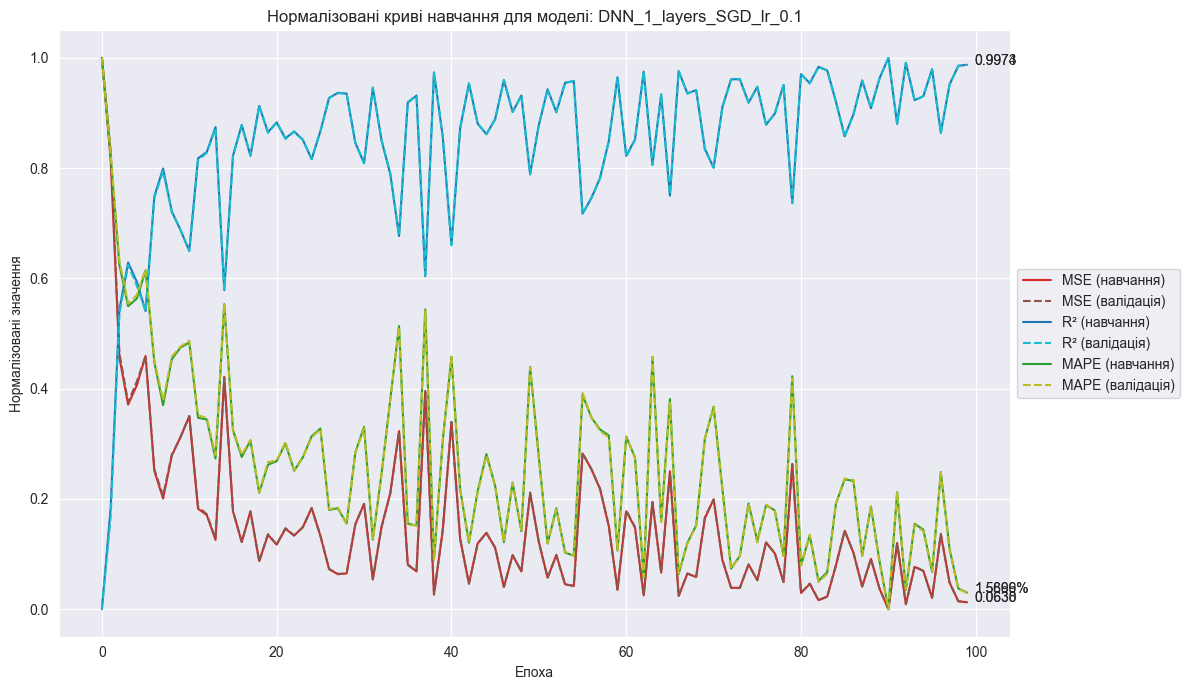

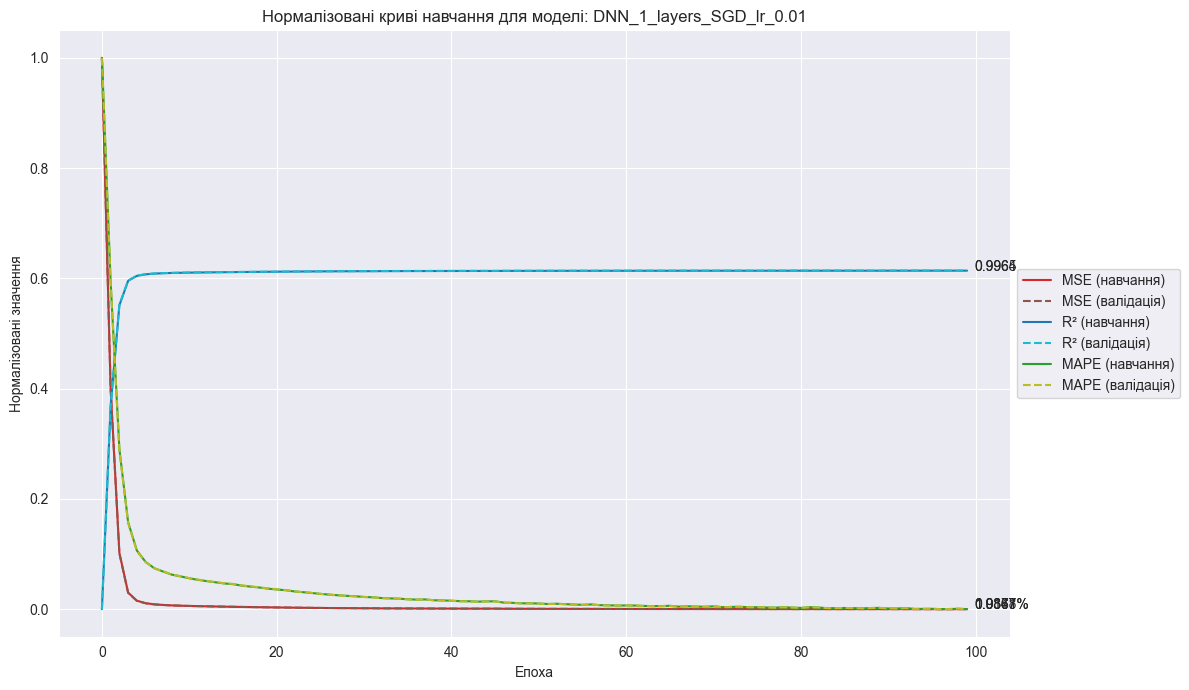

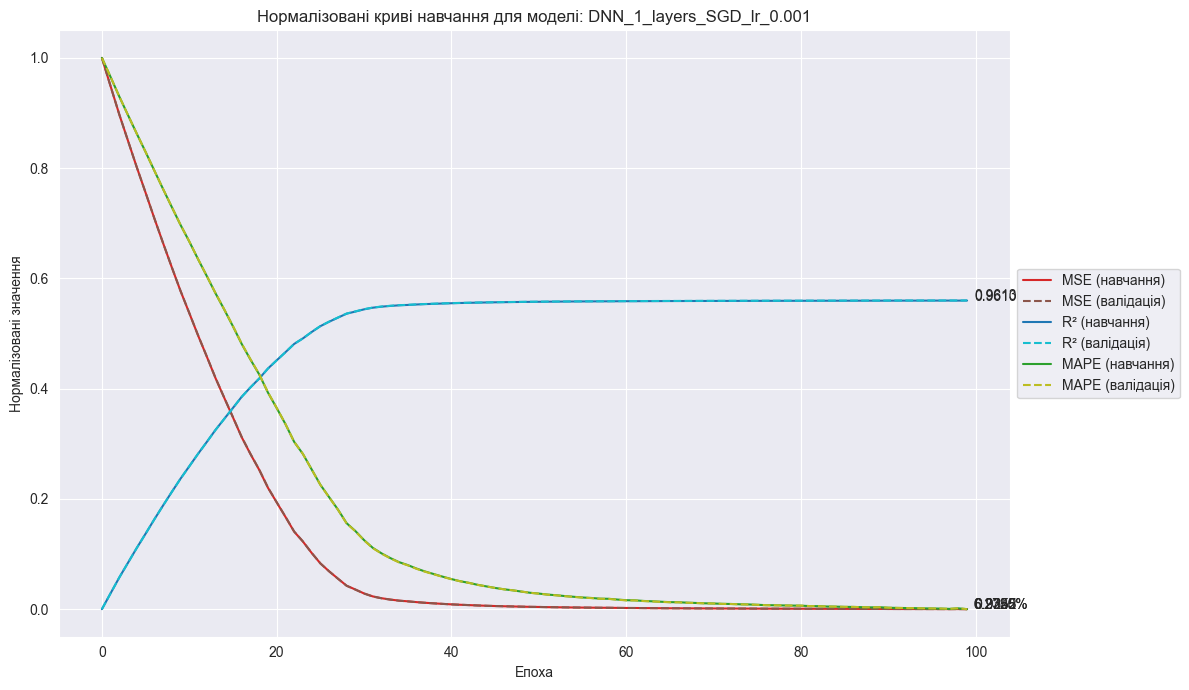

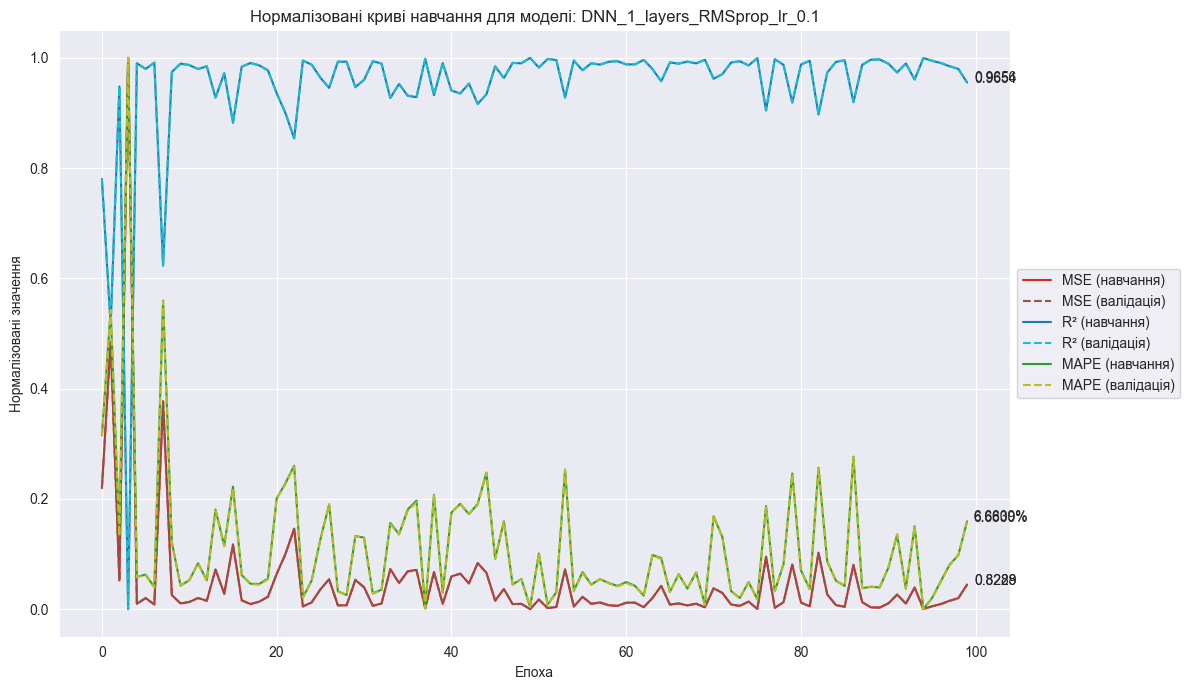

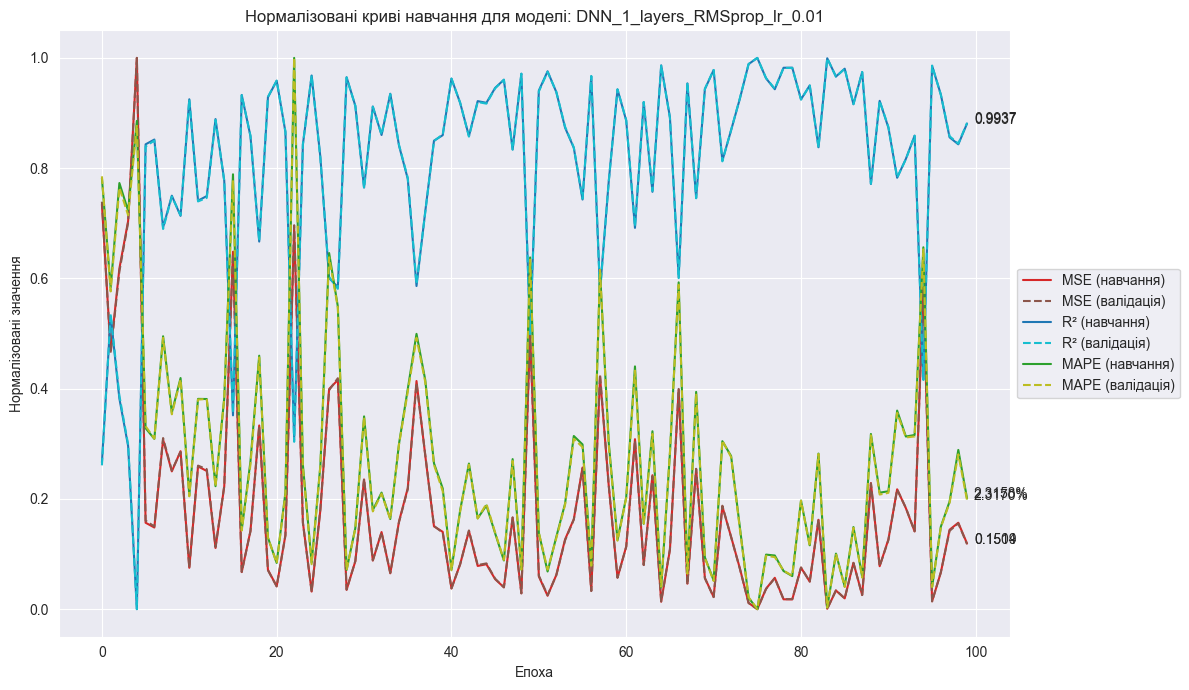

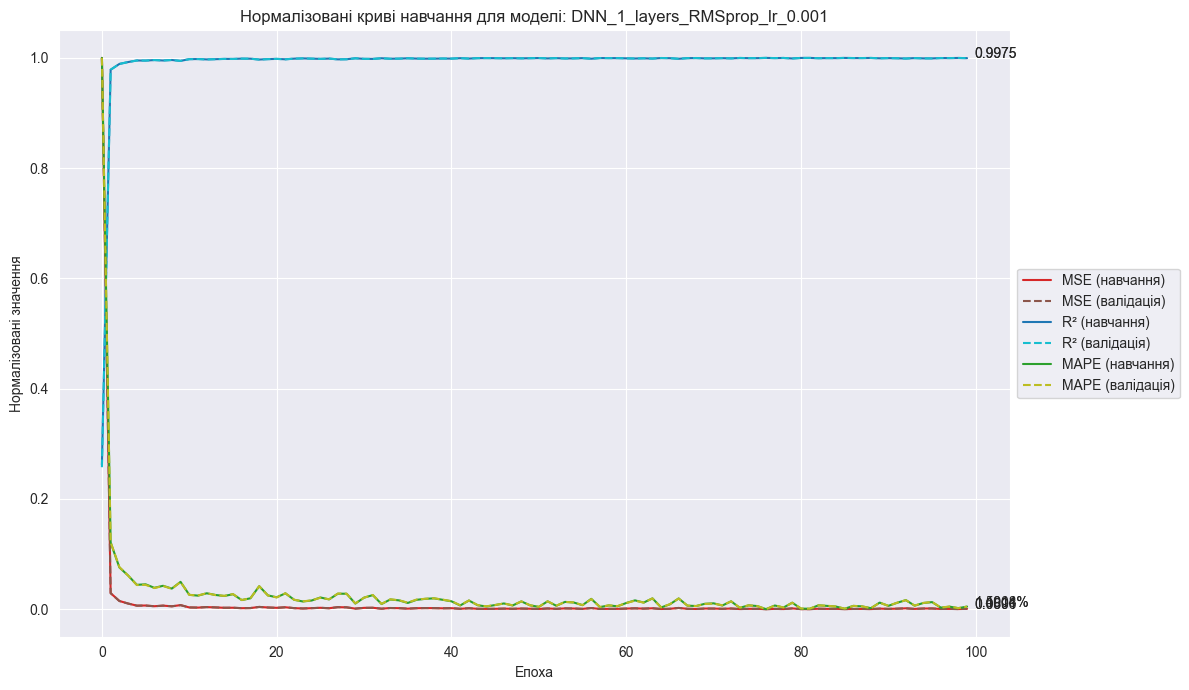

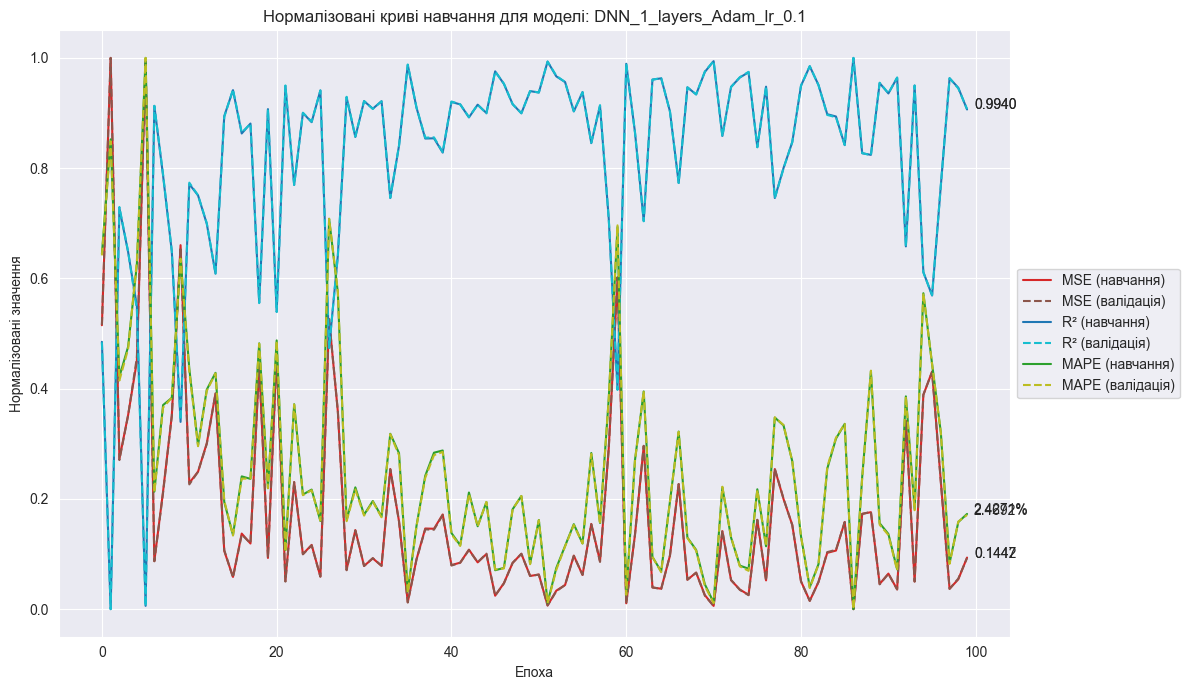

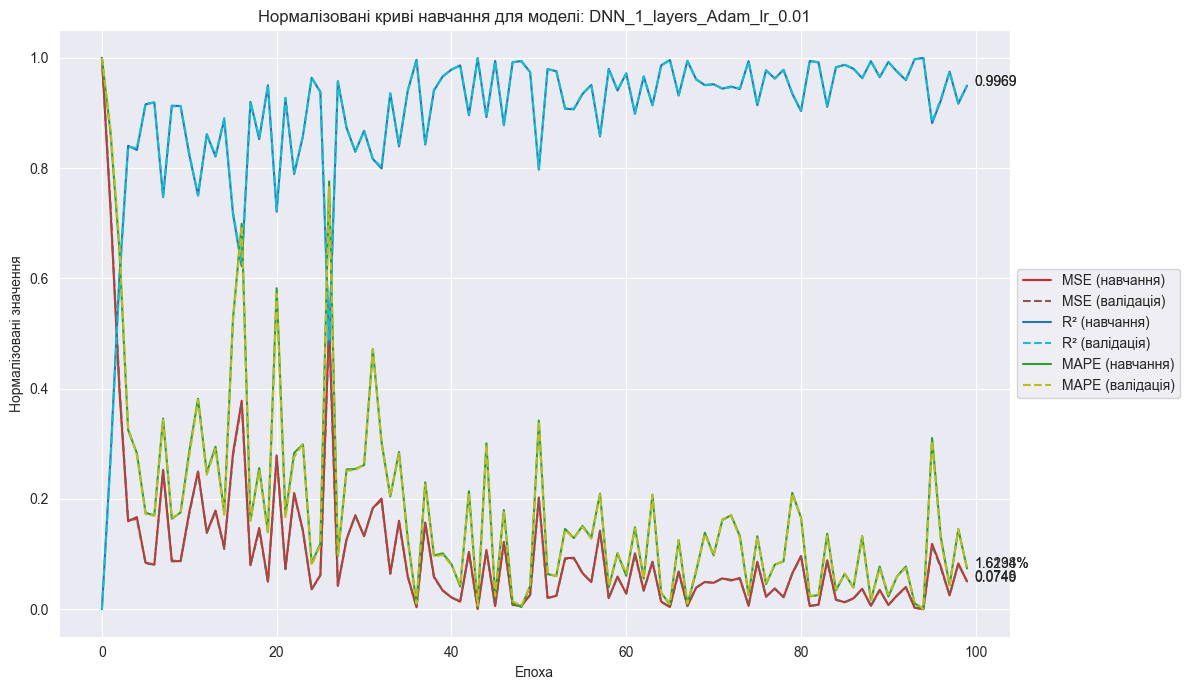

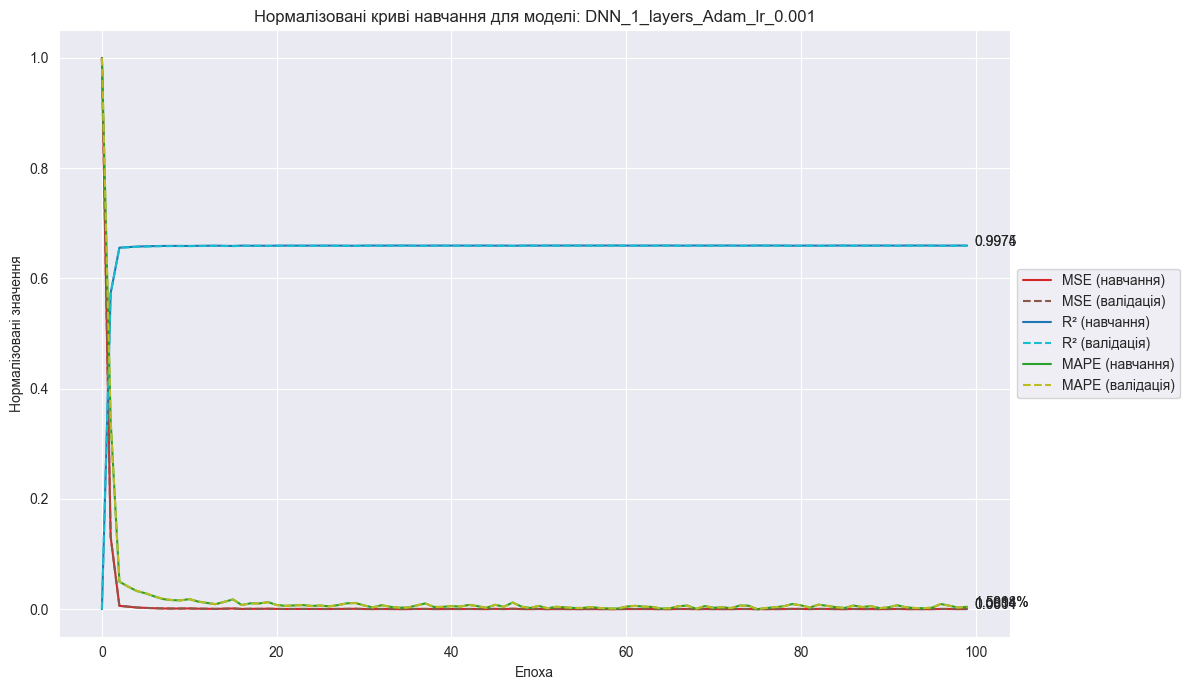

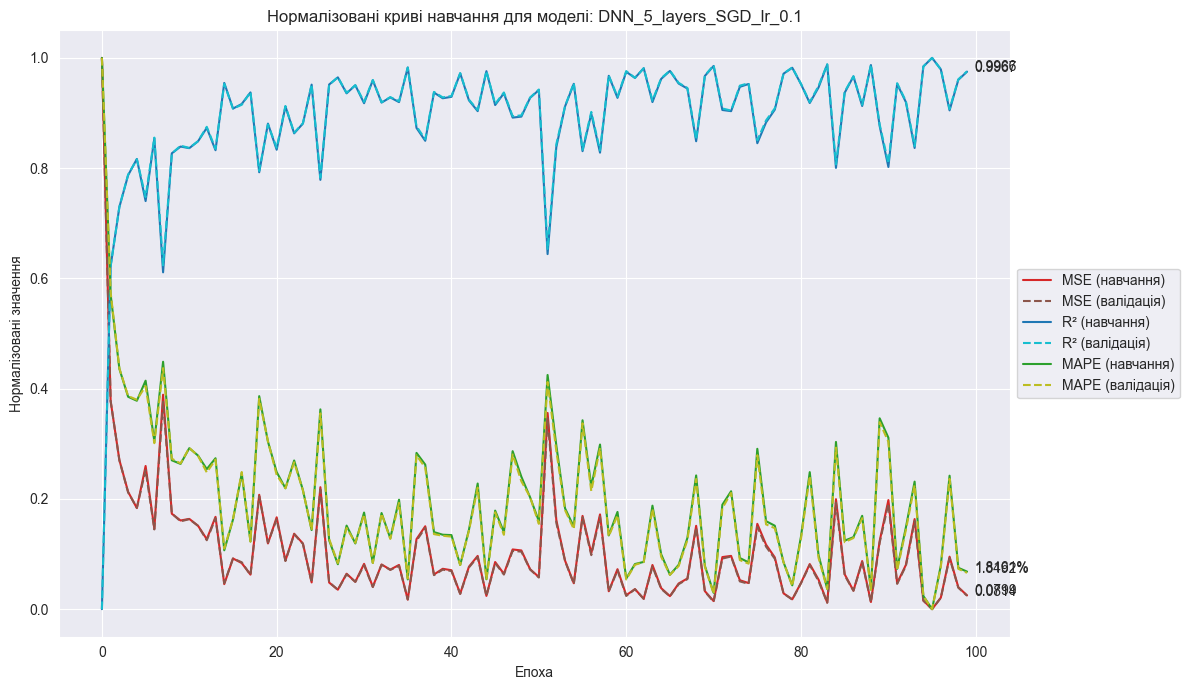

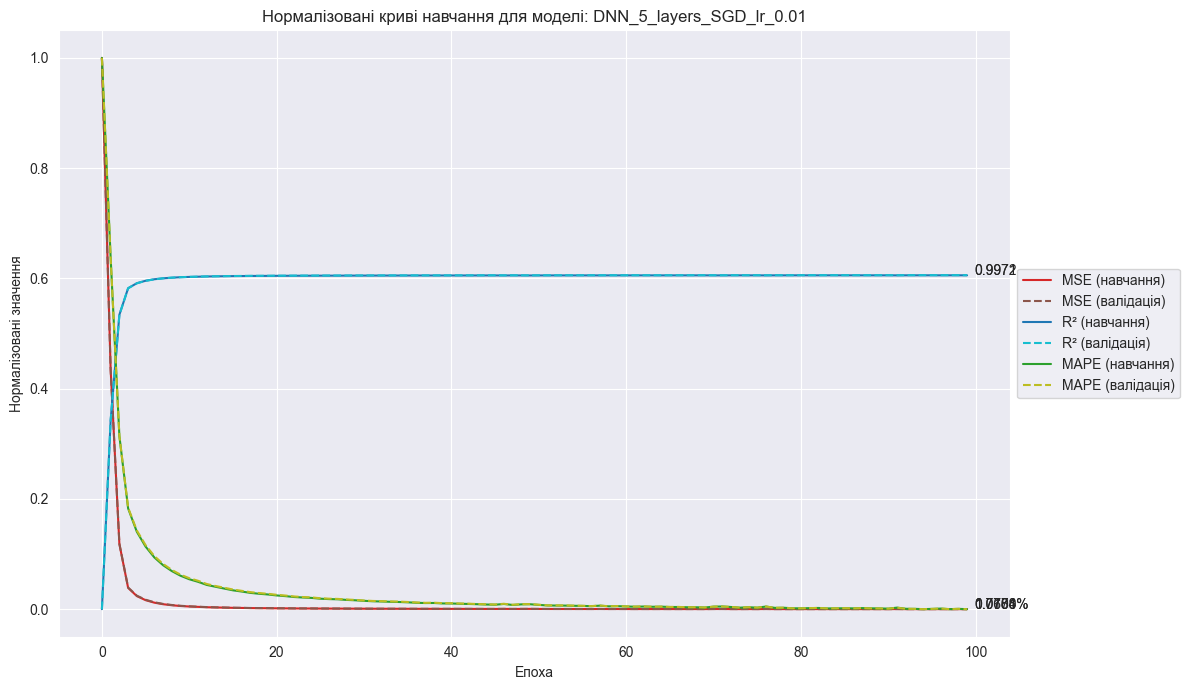

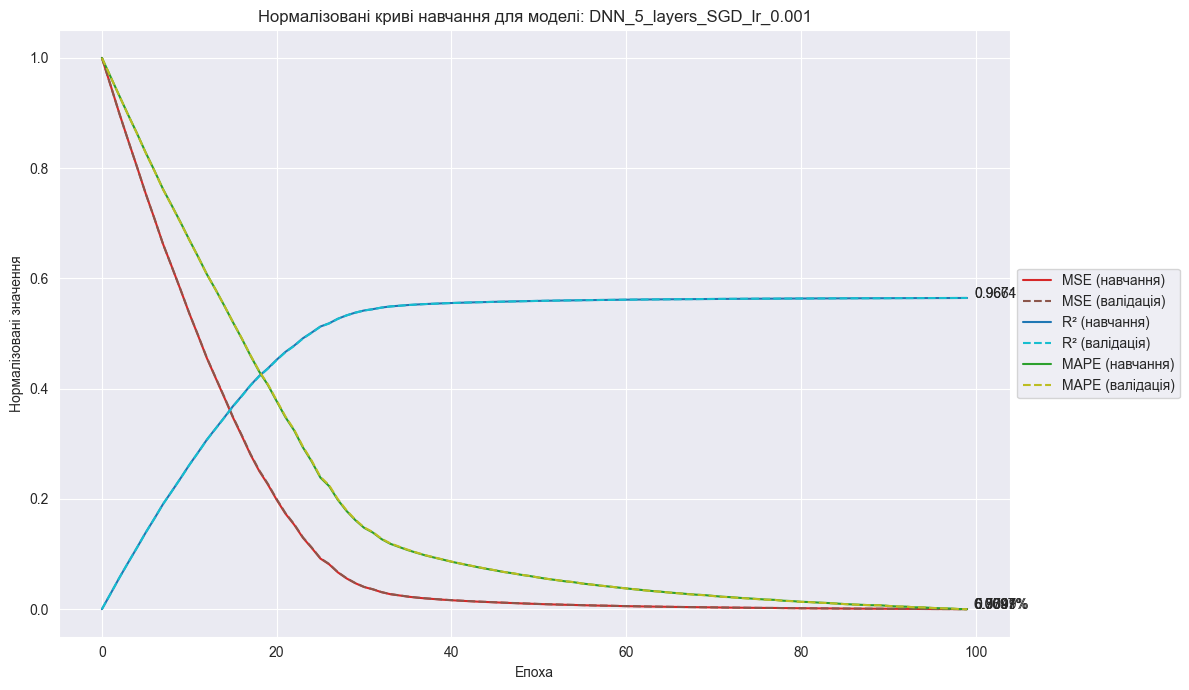

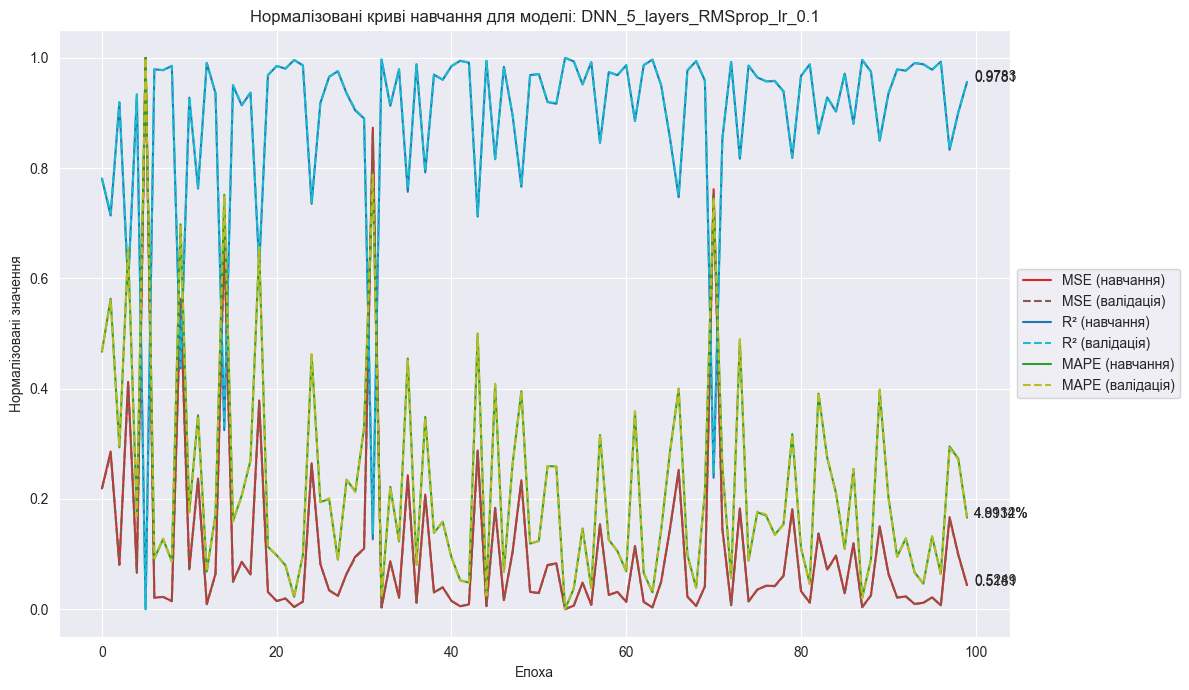

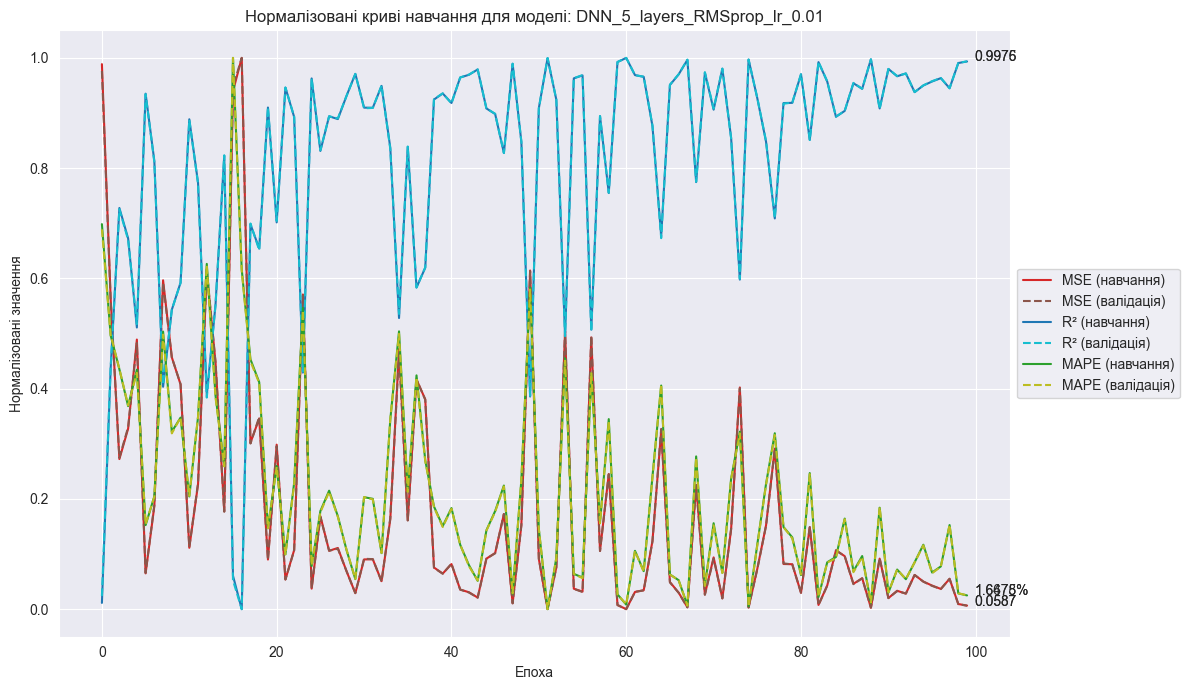

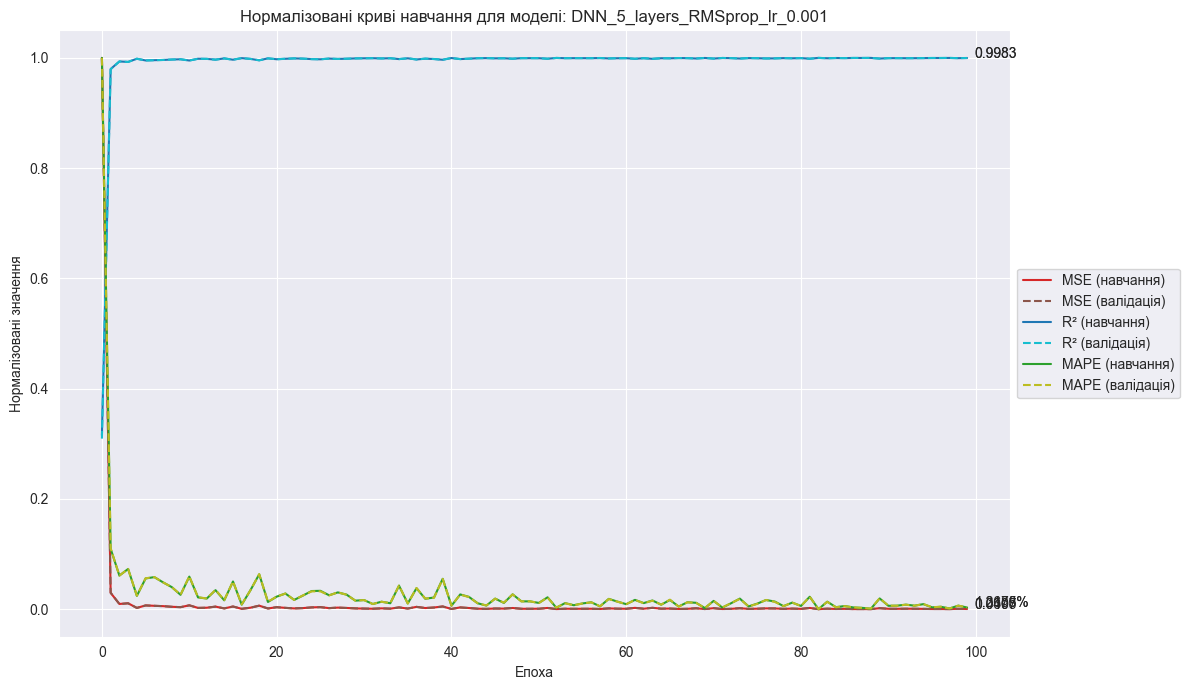

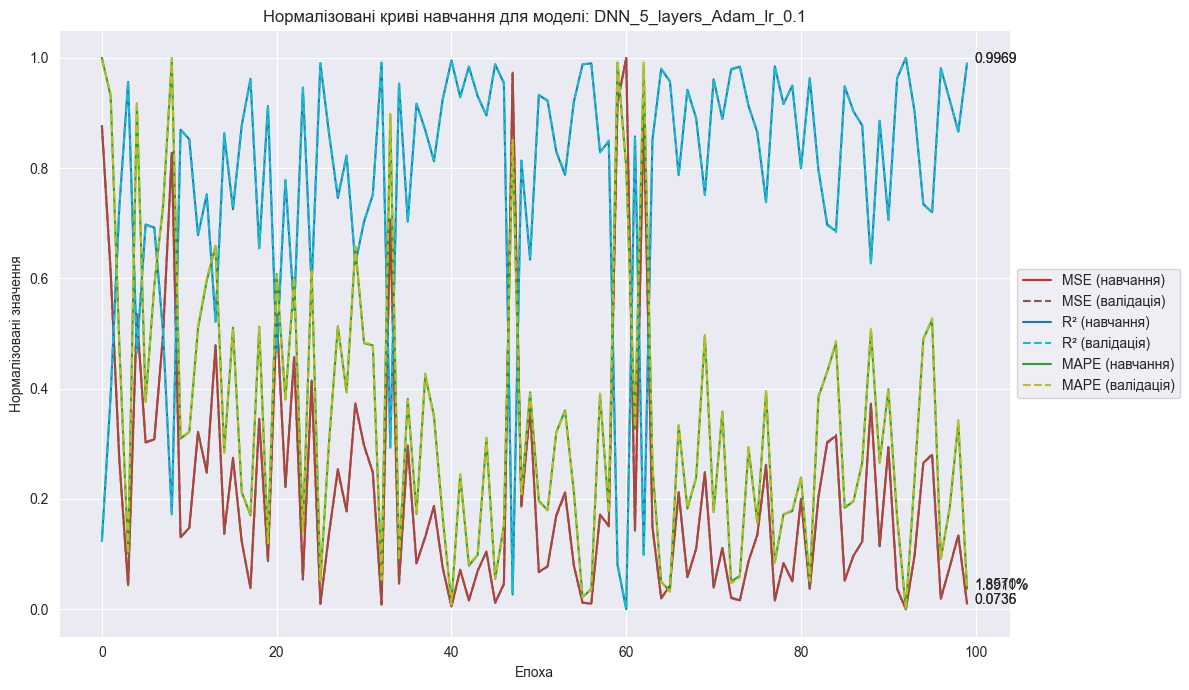

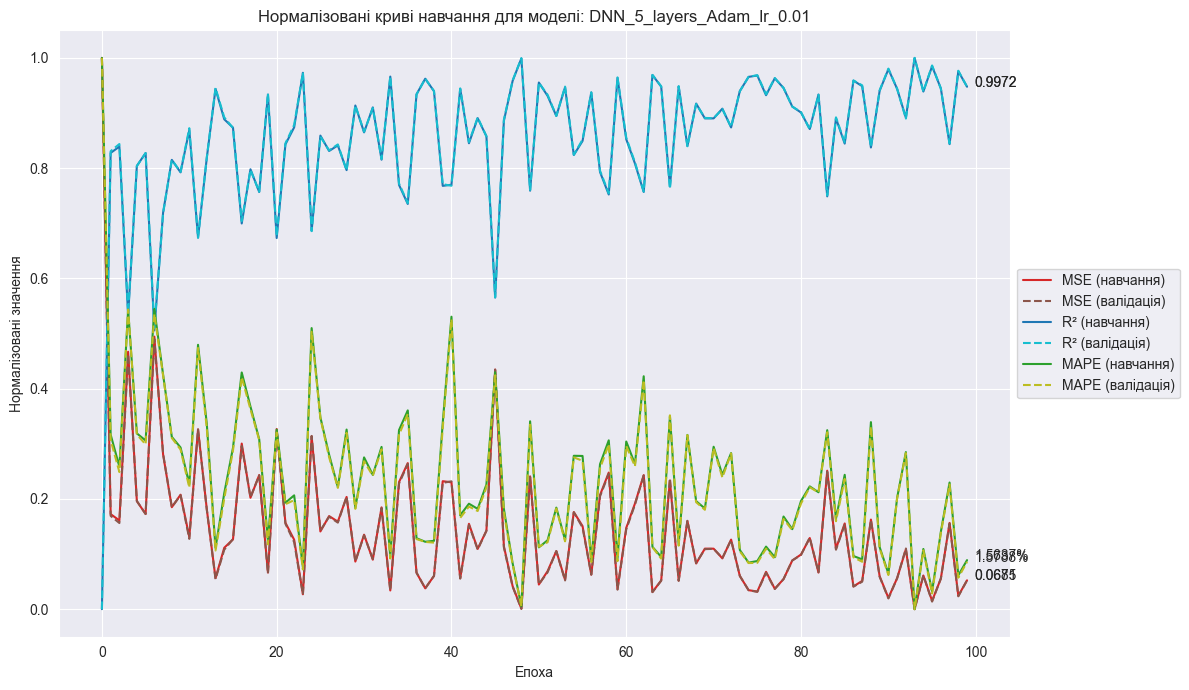

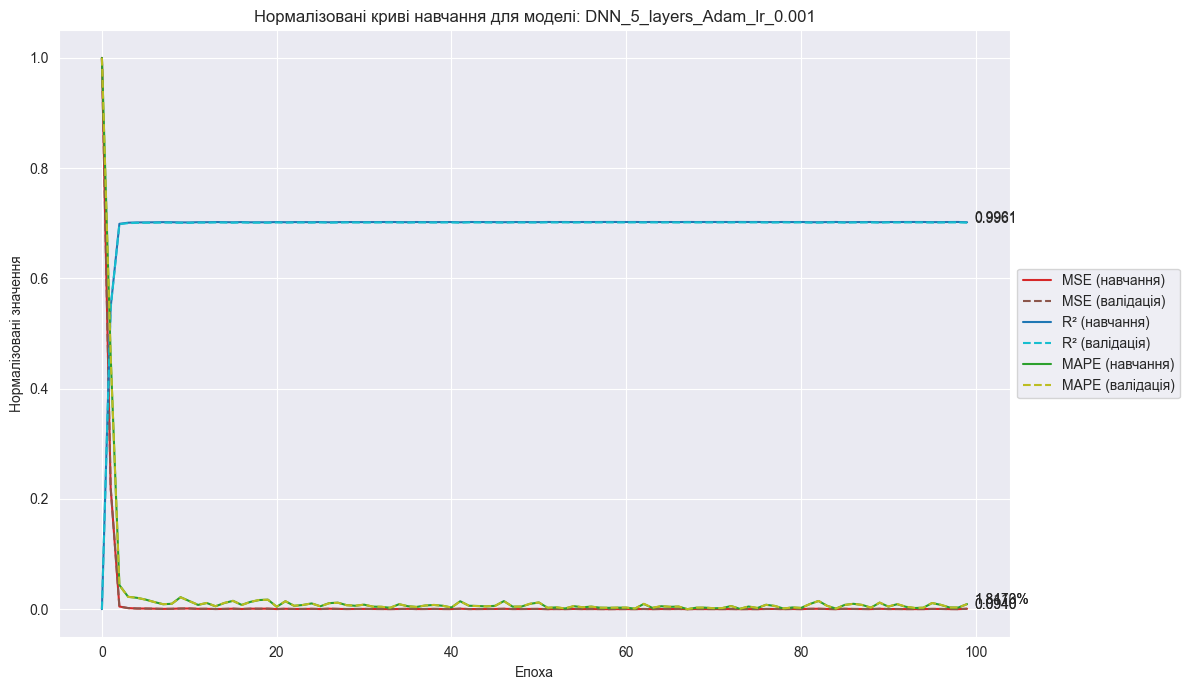

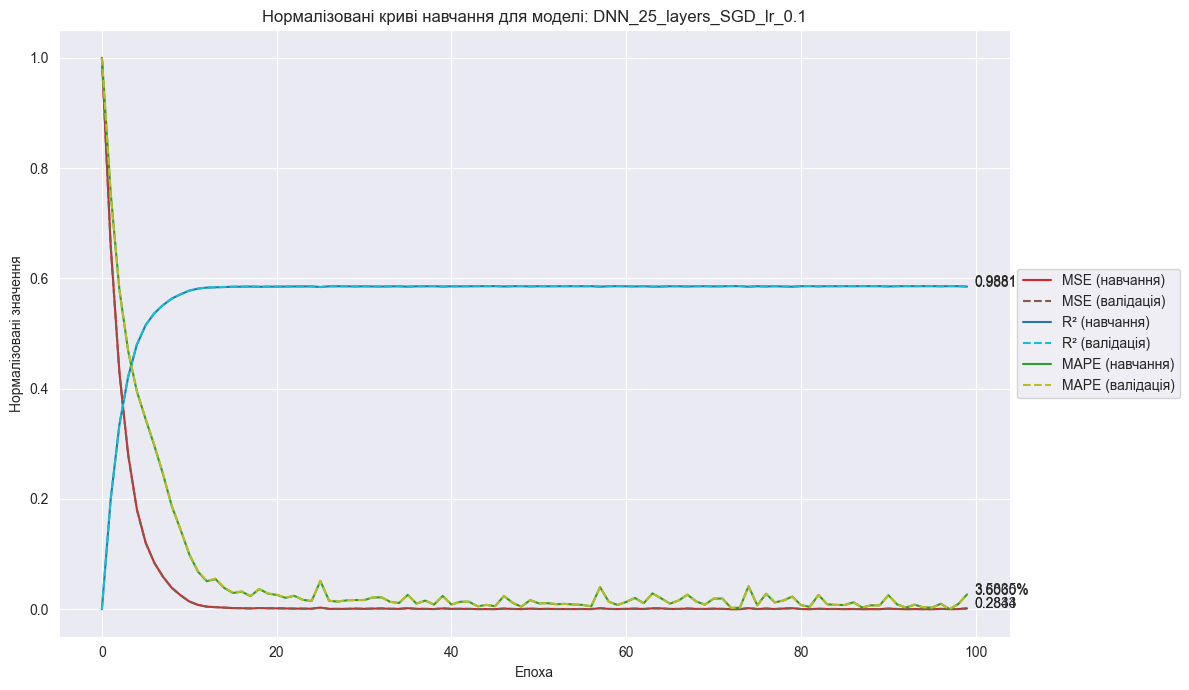

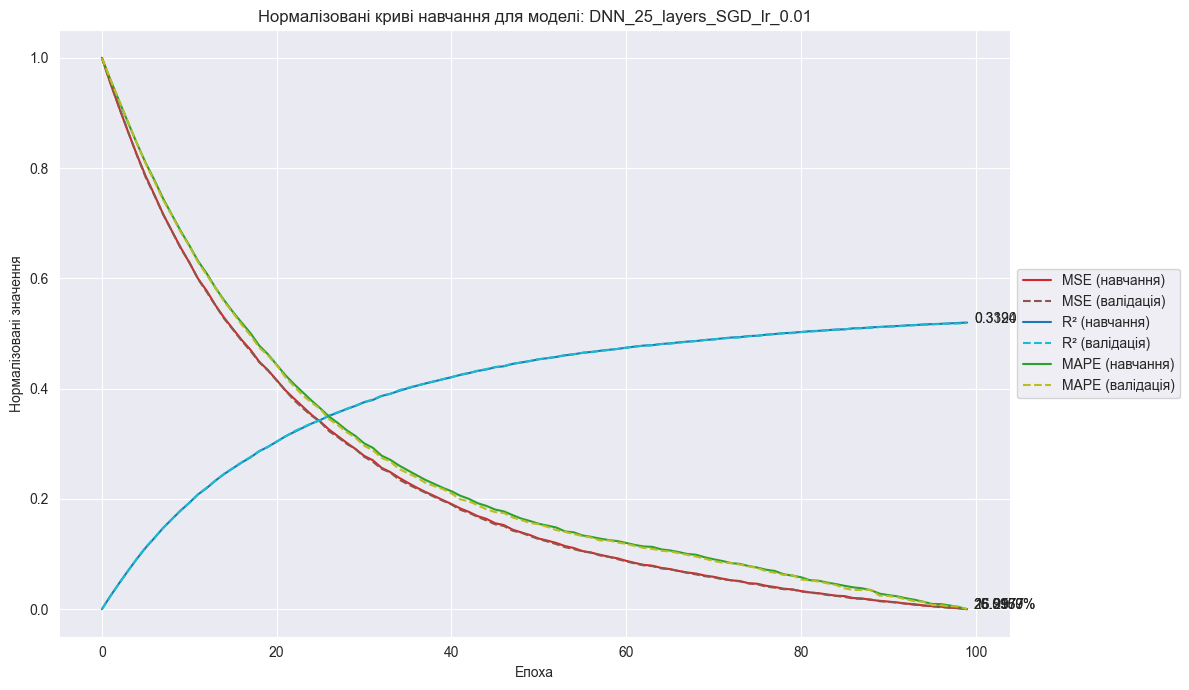

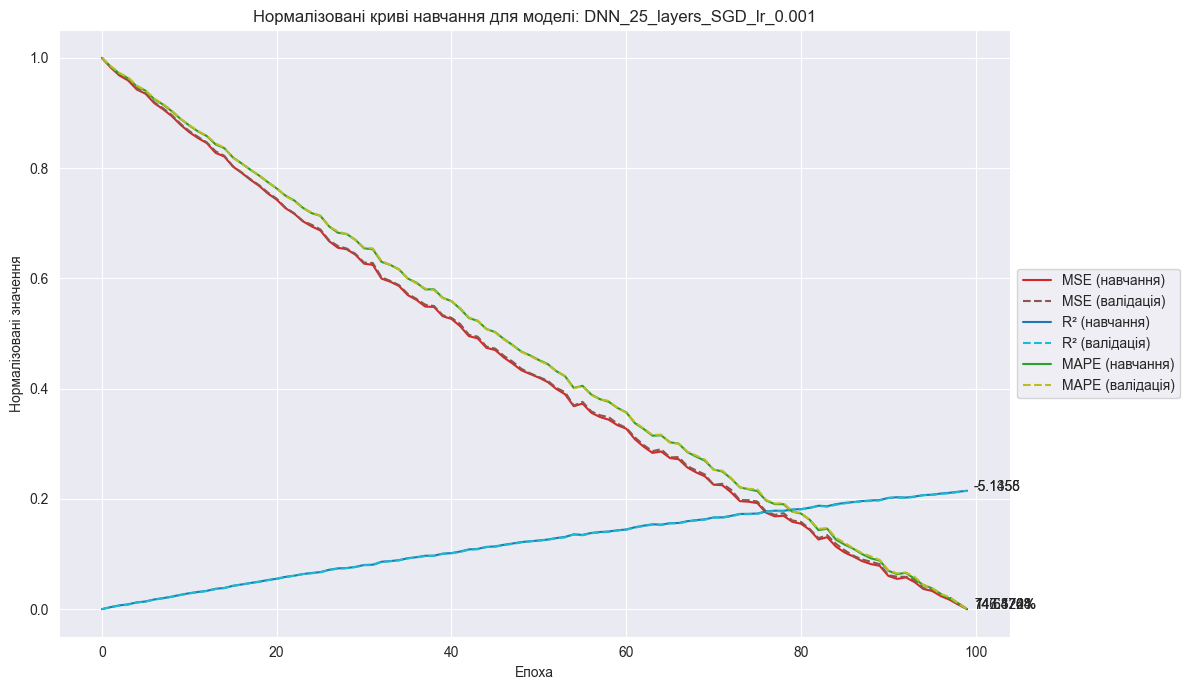

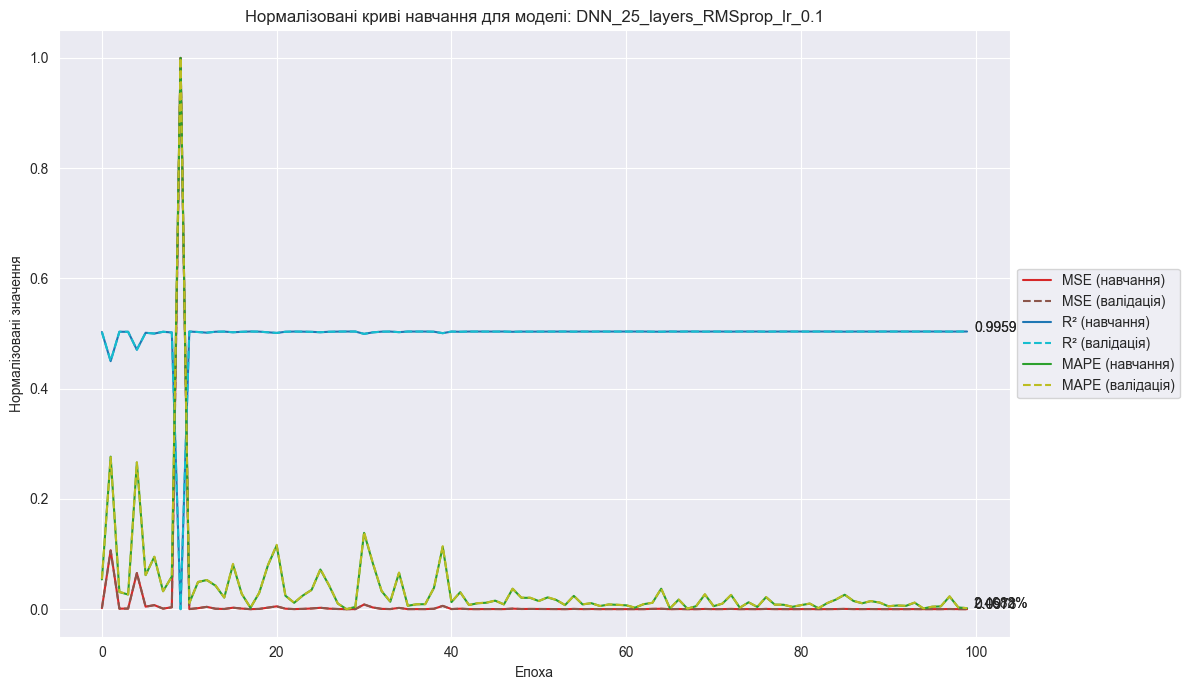

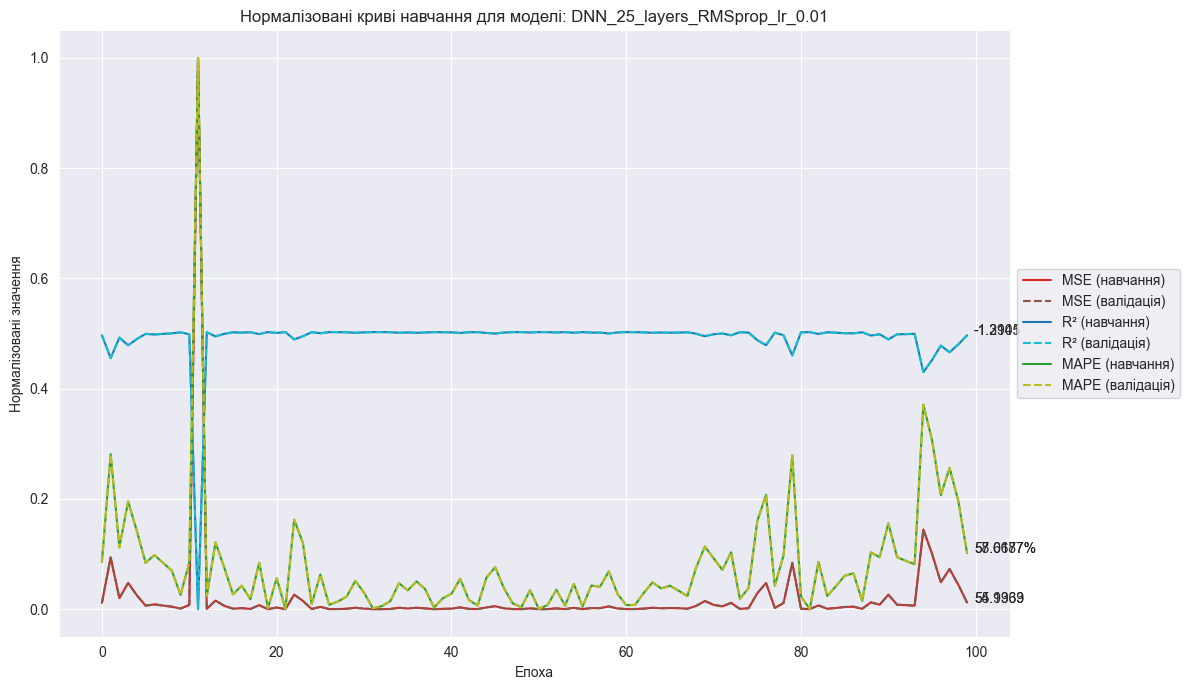

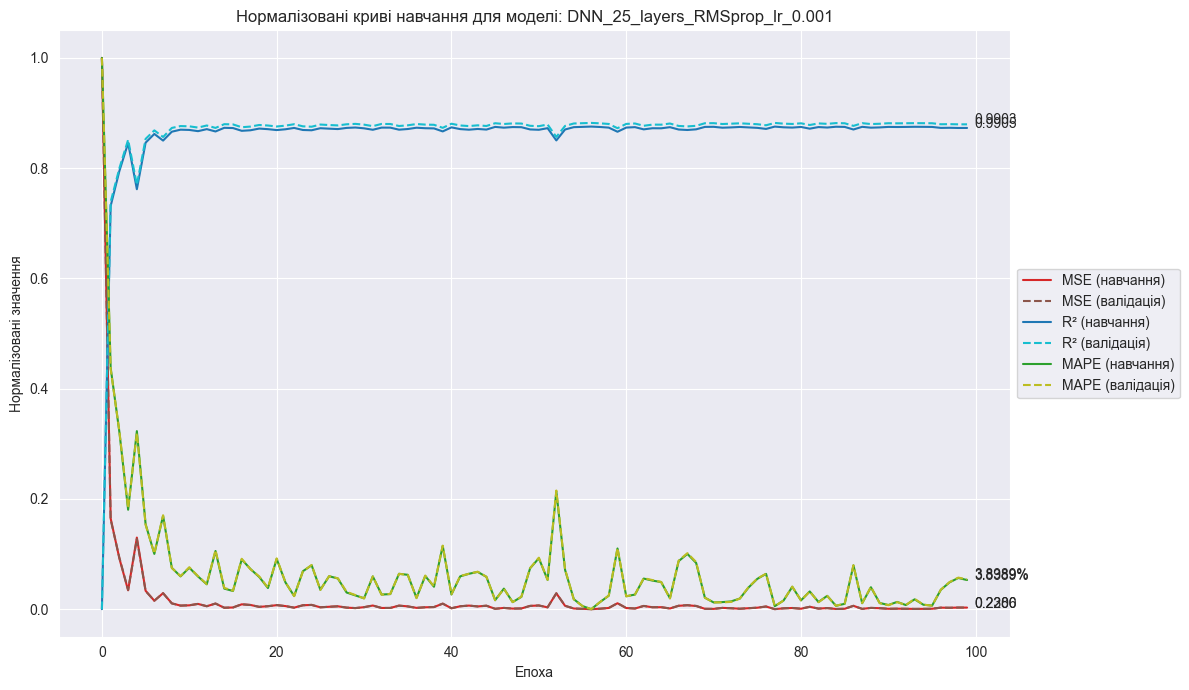

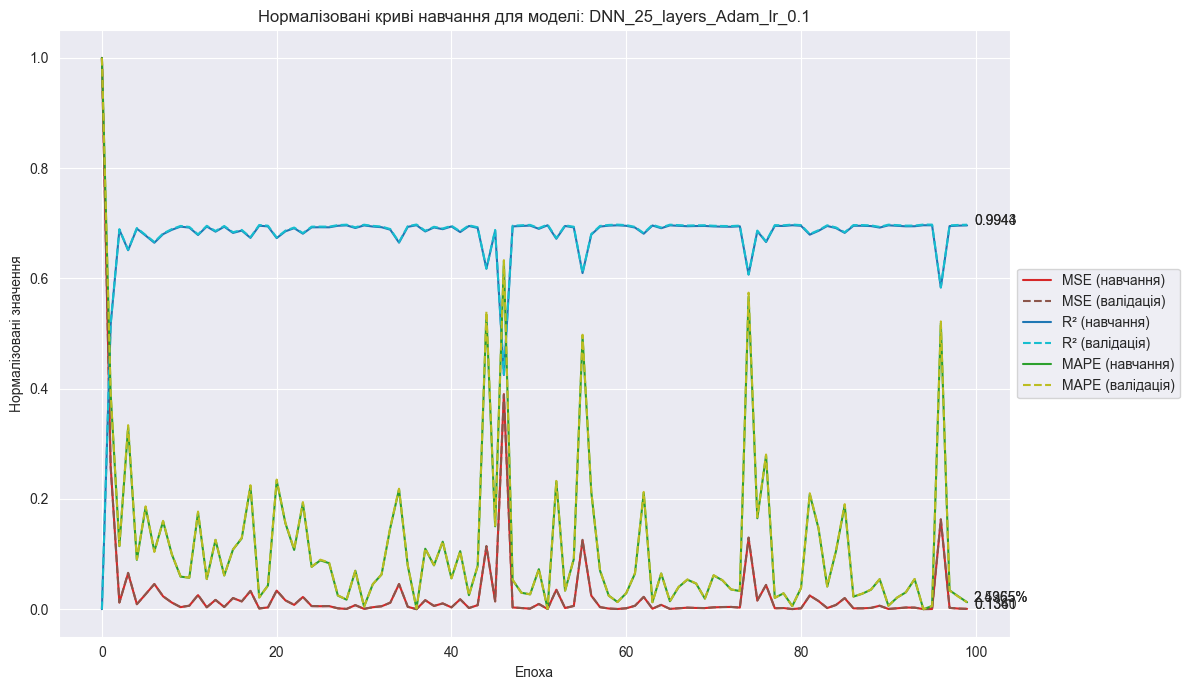

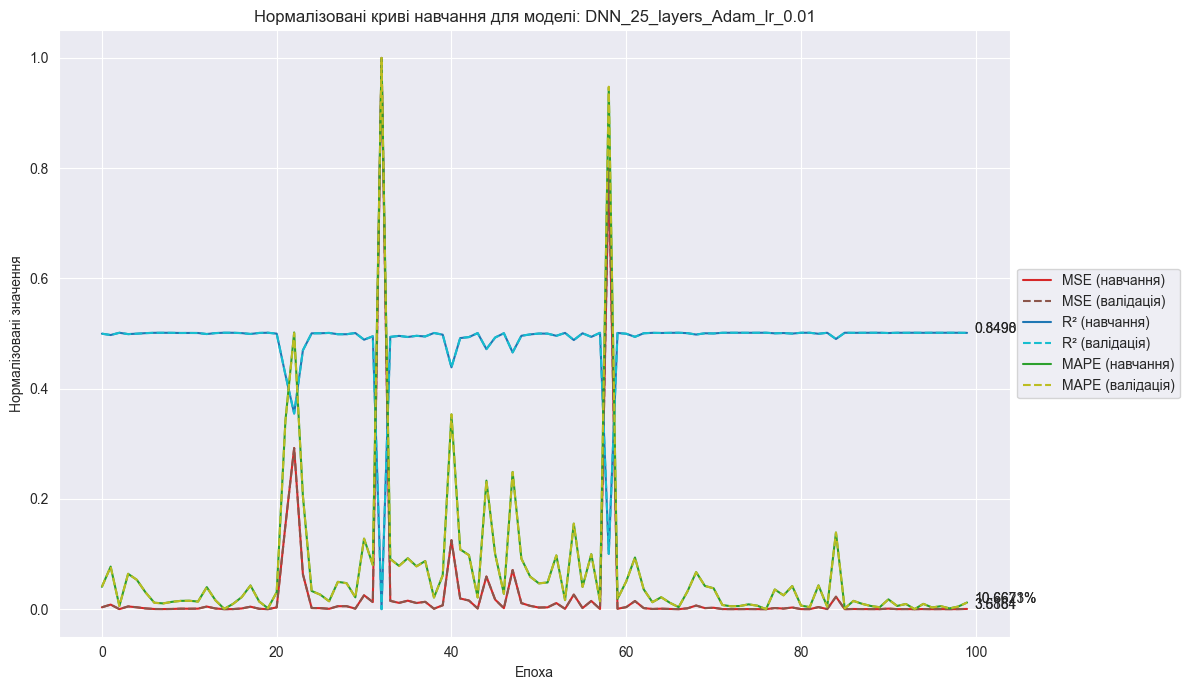

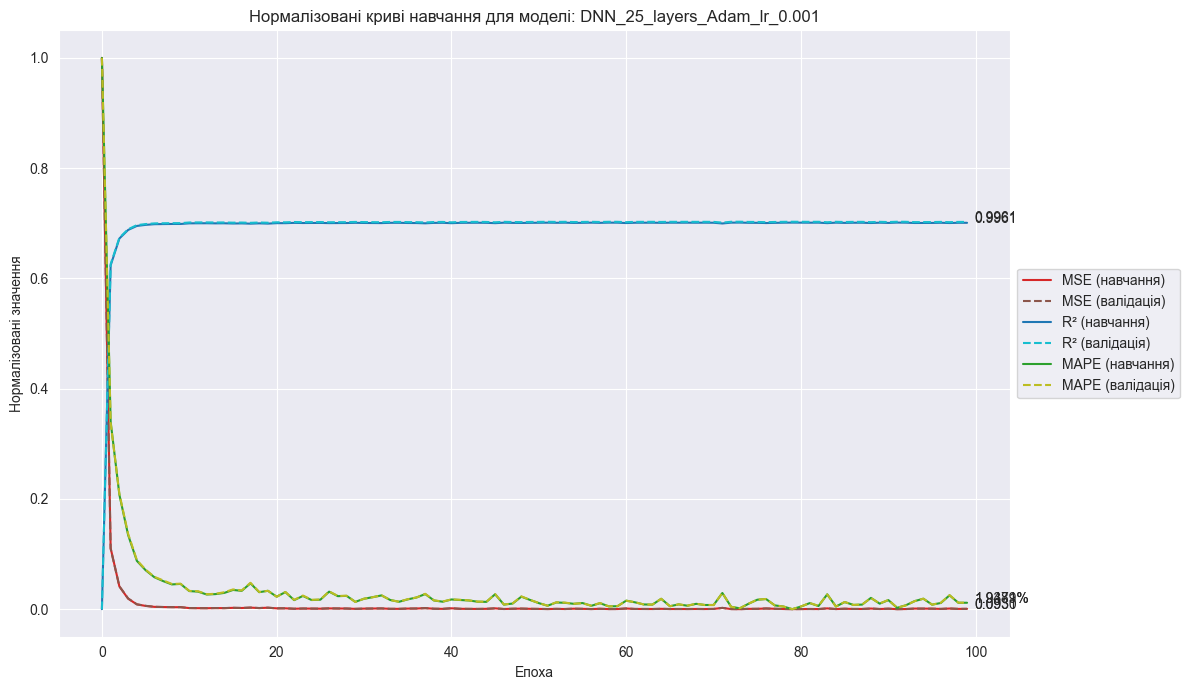

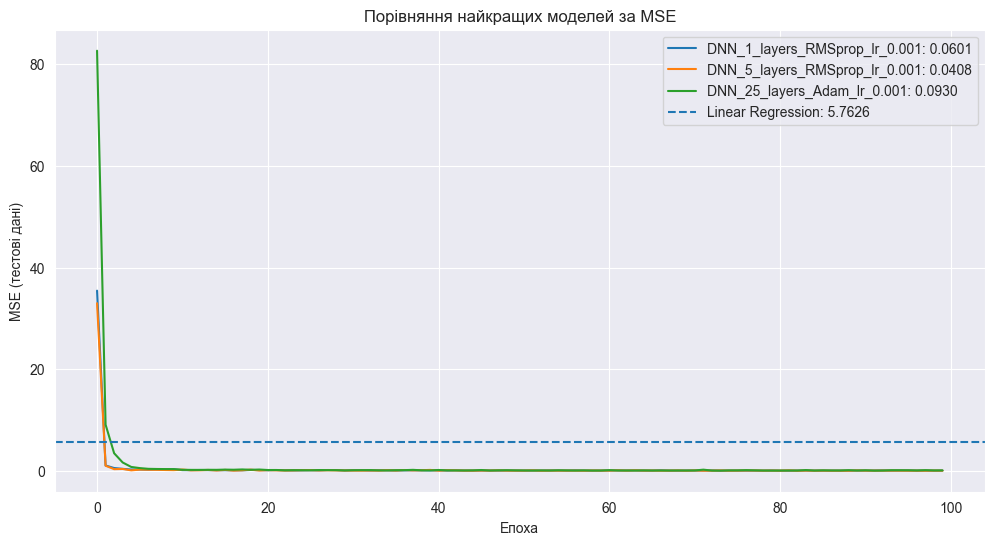

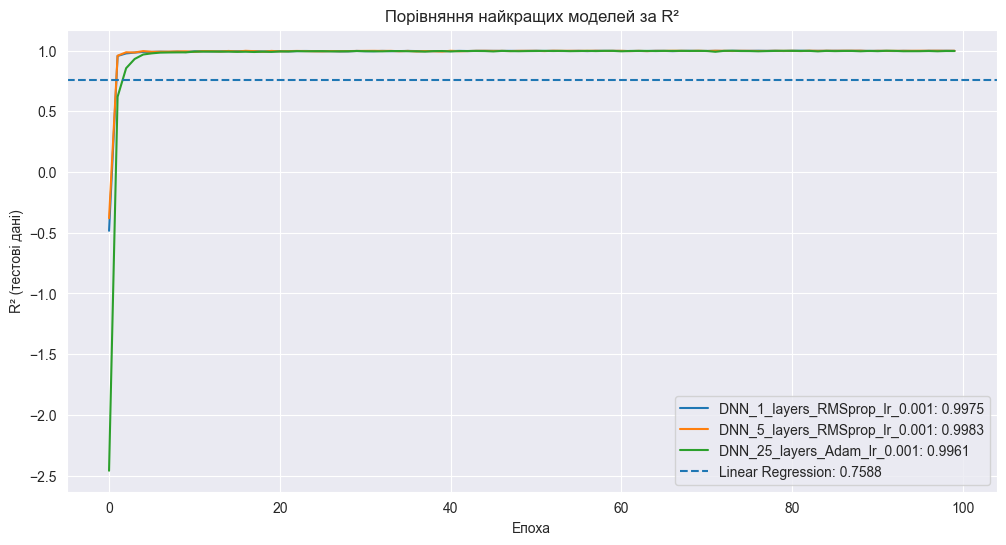

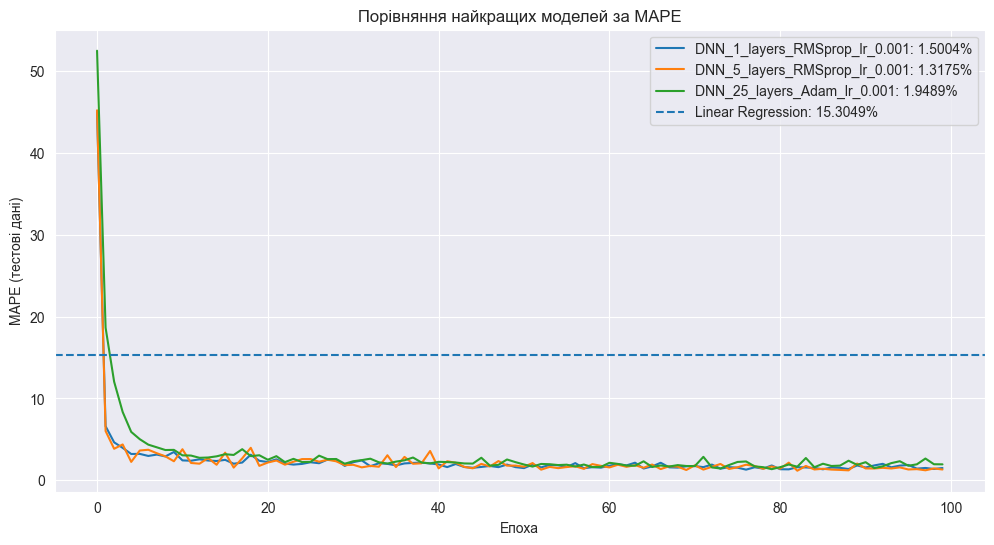

In [46]:
def plot_learning_curves_normalized(history, model_name):
    """
    Візуалізує криві навчання для заданої моделі з нормалізованими метриками на одному графіку

    Parameters:
    -----------
    history : dict
        Історія метрик навчання
    model_name : str
        Назва моделі для заголовку графіка
    """
    # Створюємо фігуру
    fig, ax = plt.subplots(figsize=(12, 7))

    # Нормалізуємо метрики до діапазону [0, 1]
    def normalize(metric):
        if len(metric) == 0:
            return []
        min_val = min(metric)
        max_val = max(metric)
        # Запобігаємо діленню на нуль
        if max_val == min_val:
            return [0.5 for _ in metric]
        return [(x - min_val) / (max_val - min_val) for x in metric]

    # Якщо R² має негативні значення, його нормалізація потребує спеціальної обробки
    def normalize_r2(metric):
        if len(metric) == 0:
            return []
        min_val = min(metric)
        max_val = max(metric)
        if min_val < 0:
            # Якщо є негативні значення, нормалізуємо відносно абсолютного максимуму
            abs_max = max(abs(min_val), abs(max_val))
            return [(x + abs_max) / (2 * abs_max) for x in metric]
        elif max_val == min_val:
            return [0.5 for _ in metric]
        else:
            return [(x - min_val) / (max_val - min_val) for x in metric]

    # Підготовка нормалізованих даних
    normalized_data = {
        'train_loss': normalize(history['train_loss']),
        'test_loss': normalize(history['test_loss']),
        'train_r2': normalize_r2(history['train_r2']),
        'test_r2': normalize_r2(history['test_r2']),
        'train_mape': normalize(history['train_mape']),
        'test_mape': normalize(history['test_mape']),
    }

    # Кольори для різних метрик
    colors = {
        'train_loss': 'tab:red',
        'test_loss': 'tab:brown',
        'train_r2': 'tab:blue',
        'test_r2': 'tab:cyan',
        'train_mape': 'tab:green',
        'test_mape': 'tab:olive'
    }

    # Стилі ліній для різних метрик
    styles = {
        'train_loss': '-',
        'test_loss': '--',
        'train_r2': '-',
        'test_r2': '--',
        'train_mape': '-',
        'test_mape': '--'
    }

    # Виведення всіх нормалізованих метрик
    for key, data in normalized_data.items():
        if key == 'train_loss':
            label = 'MSE (навчання)'
        elif key == 'test_loss':
            label = 'MSE (валідація)'
        elif key == 'train_r2':
            label = 'R² (навчання)'
        elif key == 'test_r2':
            label = 'R² (валідація)'
        elif key == 'train_mape':
            label = 'MAPE (навчання)'
        elif key == 'test_mape':
            label = 'MAPE (валідація)'

        ax.plot(data, color=colors[key], linestyle=styles[key], label=label)

    # Додавання підписів метрик (показники в кінці навчання)
    for key, data in normalized_data.items():
        if len(data) > 0:
            if key == 'train_loss':
                ax.annotate(f"{history['train_loss'][-1]:.4f}",
                            xy=(len(data)-1, data[-1]),
                            xytext=(5, 0),
                            textcoords='offset points')
            elif key == 'test_loss':
                ax.annotate(f"{history['test_loss'][-1]:.4f}",
                            xy=(len(data)-1, data[-1]),
                            xytext=(5, 0),
                            textcoords='offset points')
            elif key == 'train_r2':
                ax.annotate(f"{history['train_r2'][-1]:.4f}",
                            xy=(len(data)-1, data[-1]),
                            xytext=(5, 0),
                            textcoords='offset points')
            elif key == 'test_r2':
                ax.annotate(f"{history['test_r2'][-1]:.4f}",
                            xy=(len(data)-1, data[-1]),
                            xytext=(5, 0),
                            textcoords='offset points')
            elif key == 'train_mape':
                ax.annotate(f"{history['train_mape'][-1]:.4f}%",
                            xy=(len(data)-1, data[-1]),
                            xytext=(5, 0),
                            textcoords='offset points')
            elif key == 'test_mape':
                ax.annotate(f"{history['test_mape'][-1]:.4f}%",
                            xy=(len(data)-1, data[-1]),
                            xytext=(5, 0),
                            textcoords='offset points')

    # Налаштування графіка
    ax.set_xlabel('Епоха')
    ax.set_ylabel('Нормалізовані значення')
    ax.set_title(f'Нормалізовані криві навчання для моделі: {model_name}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)

    # Відображення
    plt.tight_layout()
    plt.show()

# Викликаємо функцію для кожної моделі
for model_name, history in histories.items():
    plot_learning_curves_normalized(history, model_name)

# Порівняння найкращих моделей для різних архітектур
def plot_best_models_comparison():
    """
    Візуалізує порівняння найкращих моделей для кожної архітектури
    """
    # Знаходимо найкращу модель для кожної кількості шарів за тестовим MSE
    best_models = {}

    for n_layers in hidden_layers_options:
        layer_models = results_df[results_df['layers'] == n_layers]
        if not layer_models.empty:
            best_model = layer_models.iloc[0]['model']  # Вже відсортовано за test_mse
            best_models[n_layers] = best_model

    # Додаємо лінійну регресію
    best_models[0] = 'Linear Regression'

    # Графік за MSE
    plt.figure(figsize=(12, 6))
    for n_layers, model_name in best_models.items():
        if n_layers == 0:  # Лінійна регресія
            plt.axhline(y=lr_results['test_mse'], linestyle='--',
                        label=f'Linear Regression: {lr_results["test_mse"]:.4f}')
        else:
            history = histories[model_name]
            plt.plot(history['test_loss'],
                     label=f'{model_name}: {history["test_loss"][-1]:.4f}')

    plt.title('Порівняння найкращих моделей за MSE')
    plt.xlabel('Епоха')
    plt.ylabel('MSE (тестові дані)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Графік за R²
    plt.figure(figsize=(12, 6))
    for n_layers, model_name in best_models.items():
        if n_layers == 0:  # Лінійна регресія
            plt.axhline(y=lr_results['test_r2'], linestyle='--',
                        label=f'Linear Regression: {lr_results["test_r2"]:.4f}')
        else:
            history = histories[model_name]
            plt.plot(history['test_r2'],
                     label=f'{model_name}: {history["test_r2"][-1]:.4f}')

    plt.title('Порівняння найкращих моделей за R²')
    plt.xlabel('Епоха')
    plt.ylabel('R² (тестові дані)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Графік за MAPE
    plt.figure(figsize=(12, 6))
    for n_layers, model_name in best_models.items():
        if n_layers == 0:  # Лінійна регресія
            plt.axhline(y=lr_results['test_mape'], linestyle='--',
                        label=f'Linear Regression: {lr_results["test_mape"]:.4f}%')
        else:
            history = histories[model_name]
            plt.plot(history['test_mape'],
                     label=f'{model_name}: {history["test_mape"][-1]:.4f}%')

    plt.title('Порівняння найкращих моделей за MAPE')
    plt.xlabel('Епоха')
    plt.ylabel('MAPE (тестові дані)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Виконуємо порівняння
plot_best_models_comparison()

# 6. Аналіз впливу різних параметрів на ефективність моделей

Проаналізуємо, як різні гіперпараметри впливають на ефективність навчання моделей:

Вплив кількості шарів на метрики:


layers   test_mse   test_r2  test_mape  train_time
0     1.0   0.265519  0.988885   2.888400  146.859385
1     5.0   0.201619  0.991560   2.545125  193.455923
2    25.0  24.716485 -0.034647  20.411333  414.118780

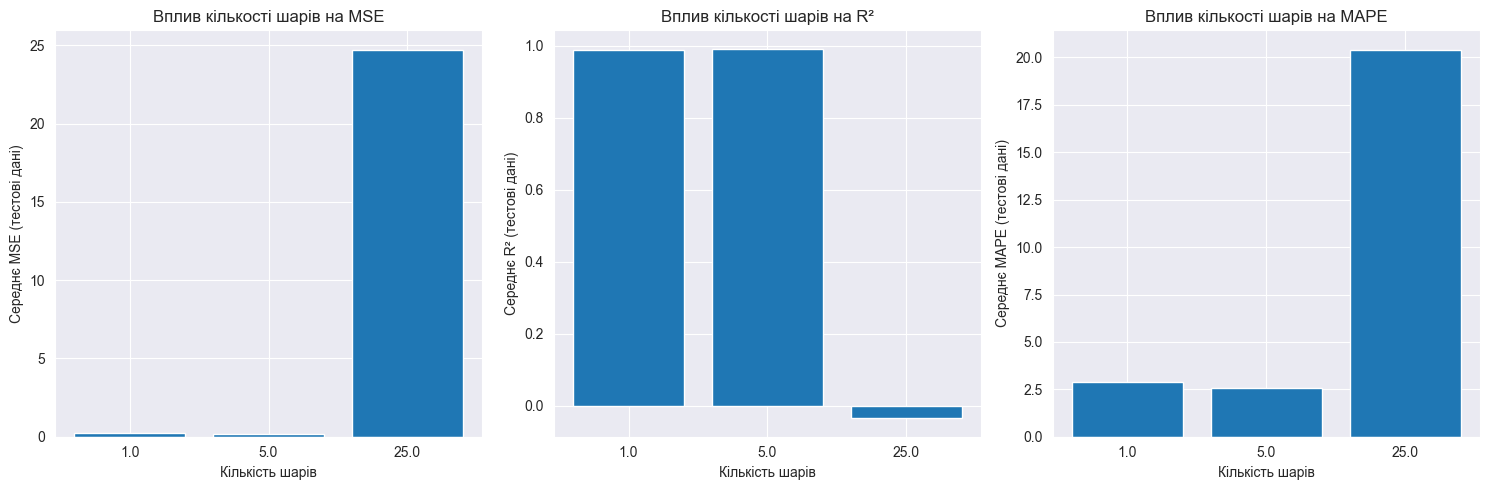

Вплив типу оптимізатора на метрики:


optimizer   test_mse   test_r2  test_mape  train_time
0      Adam   0.481252  0.979854   2.906190  254.736390
1   RMSprop   6.352542  0.734079   9.198146  254.184944
2       SGD  18.349829  0.231865  13.740523  245.512754

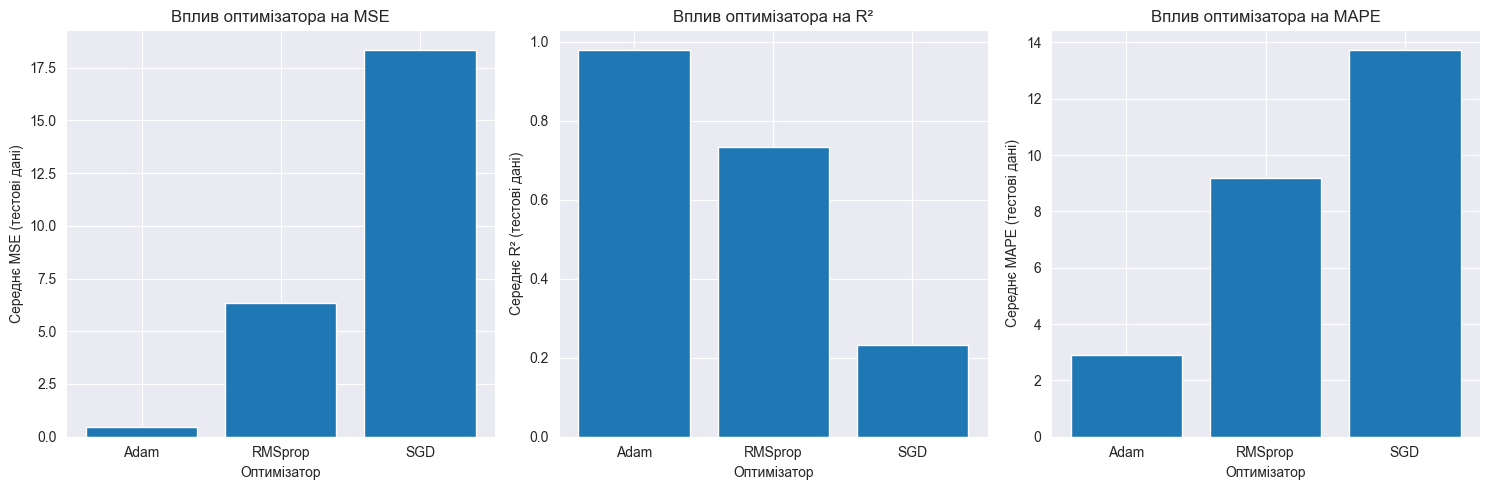

Вплив швидкості навчання на метрики:


learning_rate   test_mse   test_r2  test_mape  train_time
0          0.001  16.542821  0.307507  10.999538  249.234611
1          0.010   8.394278  0.648610  11.733963  253.795949
2          0.100   0.246523  0.989680   3.111357  251.403528

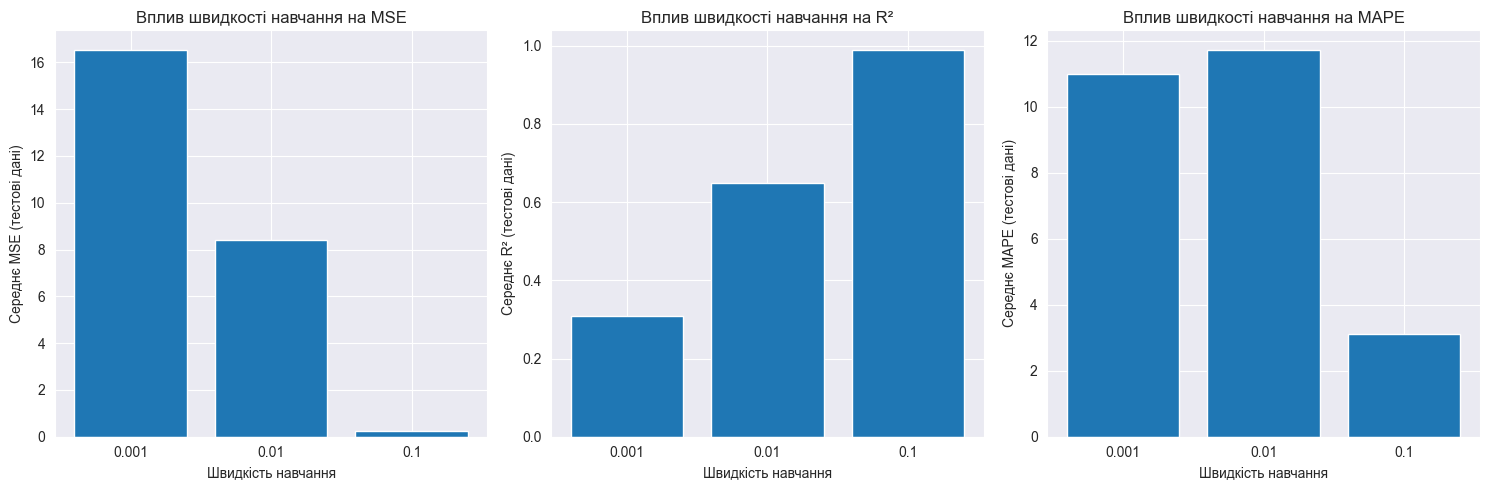

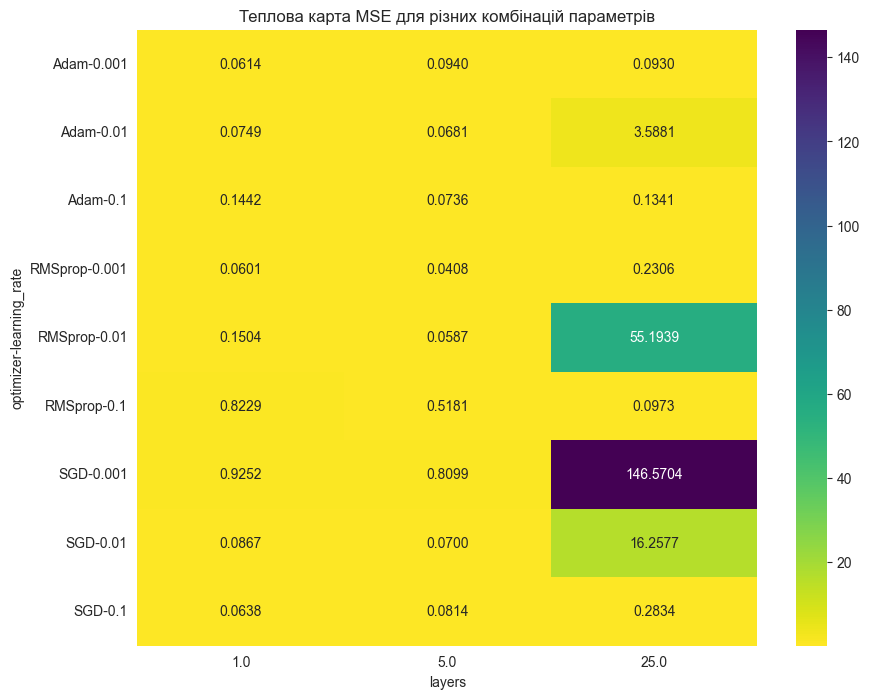

In [44]:
# Аналіз впливу кількості шарів
layer_analysis = results_df.groupby('layers').agg({
    'test_mse': 'mean',
    'test_r2': 'mean',
    'test_mape': 'mean',
    'train_time': 'mean'
}).reset_index()

print("Вплив кількості шарів на метрики:")
display(layer_analysis)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(layer_analysis['layers'].astype(str), layer_analysis['test_mse'])
plt.title('Вплив кількості шарів на MSE')
plt.xlabel('Кількість шарів')
plt.ylabel('Середнє MSE (тестові дані)')
plt.grid(True, axis='y')

plt.subplot(1, 3, 2)
plt.bar(layer_analysis['layers'].astype(str), layer_analysis['test_r2'])
plt.title('Вплив кількості шарів на R²')
plt.xlabel('Кількість шарів')
plt.ylabel('Середнє R² (тестові дані)')
plt.grid(True, axis='y')

plt.subplot(1, 3, 3)
plt.bar(layer_analysis['layers'].astype(str), layer_analysis['test_mape'])
plt.title('Вплив кількості шарів на MAPE')
plt.xlabel('Кількість шарів')
plt.ylabel('Середнє MAPE (тестові дані)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Аналіз впливу оптимізаторів
opt_analysis = results_df[results_df['model'] != 'Linear Regression'].groupby('optimizer').agg({
    'test_mse': 'mean',
    'test_r2': 'mean',
    'test_mape': 'mean',
    'train_time': 'mean'
}).reset_index()

print("Вплив типу оптимізатора на метрики:")
display(opt_analysis)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(opt_analysis['optimizer'], opt_analysis['test_mse'])
plt.title('Вплив оптимізатора на MSE')
plt.xlabel('Оптимізатор')
plt.ylabel('Середнє MSE (тестові дані)')
plt.grid(True, axis='y')

plt.subplot(1, 3, 2)
plt.bar(opt_analysis['optimizer'], opt_analysis['test_r2'])
plt.title('Вплив оптимізатора на R²')
plt.xlabel('Оптимізатор')
plt.ylabel('Середнє R² (тестові дані)')
plt.grid(True, axis='y')

plt.subplot(1, 3, 3)
plt.bar(opt_analysis['optimizer'], opt_analysis['test_mape'])
plt.title('Вплив оптимізатора на MAPE')
plt.xlabel('Оптимізатор')
plt.ylabel('Середнє MAPE (тестові дані)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Аналіз впливу швидкості навчання
lr_analysis = results_df[results_df['model'] != 'Linear Regression'].groupby('learning_rate').agg({
    'test_mse': 'mean',
    'test_r2': 'mean',
    'test_mape': 'mean',
    'train_time': 'mean'
}).reset_index()

print("Вплив швидкості навчання на метрики:")
display(lr_analysis)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(lr_analysis['learning_rate'].astype(str), lr_analysis['test_mse'])
plt.title('Вплив швидкості навчання на MSE')
plt.xlabel('Швидкість навчання')
plt.ylabel('Середнє MSE (тестові дані)')
plt.grid(True, axis='y')

plt.subplot(1, 3, 2)
plt.bar(lr_analysis['learning_rate'].astype(str), lr_analysis['test_r2'])
plt.title('Вплив швидкості навчання на R²')
plt.xlabel('Швидкість навчання')
plt.ylabel('Середнє R² (тестові дані)')
plt.grid(True, axis='y')

plt.subplot(1, 3, 3)
plt.bar(lr_analysis['learning_rate'].astype(str), lr_analysis['test_mape'])
plt.title('Вплив швидкості навчання на MAPE')
plt.xlabel('Швидкість навчання')
plt.ylabel('Середнє MAPE (тестові дані)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Аналіз взаємодії параметрів (тепло-карти)
pivot_data = results_df[results_df['model'] != 'Linear Regression'].pivot_table(
    values='test_mse',
    index=['optimizer', 'learning_rate'],
    columns='layers'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='viridis_r')
plt.title('Теплова карта MSE для різних комбінацій параметрів')
plt.show()

# 7. Висновки: порівняння з базовою моделлю та рекомендації

In [45]:
# Порівняння найкращої нейромережі з лінійною регресією
best_nn_model = results_df[results_df['model'] != 'Linear Regression'].iloc[0]
linear_model = results_df[results_df['model'] == 'Linear Regression'].iloc[0]

improvement_mse = (linear_model['test_mse'] - best_nn_model['test_mse']) / linear_model['test_mse'] * 100
improvement_r2 = (best_nn_model['test_r2'] - linear_model['test_r2']) / abs(linear_model['test_r2']) * 100
improvement_mape = (linear_model['test_mape'] - best_nn_model['test_mape']) / linear_model['test_mape'] * 100

print("Порівняння найкращої нейронної мережі з лінійною регресією:")
print(f"Найкраща нейромережа: {best_nn_model['model']}")
print(f"Покращення MSE: {improvement_mse:.2f}%")
print(f"Покращення R²: {improvement_r2:.2f}%")
print(f"Покращення MAPE: {improvement_mape:.2f}%")

Порівняння найкращої нейронної мережі з лінійною регресією:
Найкраща нейромережа: DNN_5_layers_RMSprop_lr_0.001
Покращення MSE: 99.29%
Покращення R²: 31.57%
Покращення MAPE: 91.39%


# 8. Загальні висновки та рекомендації
Найкраща нейронна мережа: DNN_5_layers_RMSprop_lr_0.001
Покращення порівняно з лінійною регресією:
  MSE: 99.29%
  R²: 31.57%
  MAPE: 91.39%

Детальні висновки щодо впливу гіперпараметрів:
1. Кількість шарів:
   Оптимальна кількість шарів: 5.0

2. Оптимізатор:
   Найефективніший оптимізатор: Adam

3. Швидкість навчання:
   Оптимальна швидкість навчання: 0.1

4. Найкраща комбінація параметрів:
   5.0 шарів, RMSprop, LR=0.001

5. Про розподіл даних:
   Дані мають значну лінійну складову, але нейронні мережі змогли вловити нелінійні залежності

Рекомендації для подібних задач:
1. Використовувати нейронні мережі з 5.0 шарами
2. Застосовувати оптимізатор Adam
3. Встановлювати швидкість навчання близько 0.1
4. Проводити регуляризацію для глибоких мереж, якщо спостерігається перенавчання
5. Використовувати batch normalization для стабілізації навчання глибоких мереж

================================================================================================

In [49]:
import pandas as pd
import json
import pickle
import os
from datetime import datetime

# Функція для збереження результатів у файли
def save_training_results(results_df, histories):
    """
    Зберігає результати тренувань у файли

    Parameters:
    -----------
    results_df : DataFrame
        Датафрейм з результатами всіх моделей
    histories : dict
        Словник з історіями навчання для кожної моделі
    """
    # Створюємо директорію для збереження результатів, якщо вона не існує
    results_dir = f'results'
    os.makedirs(results_dir, exist_ok=True)

    # Отримуємо поточну дату і час для унікальних імен файлів
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. Зберігаємо таблицю результатів у CSV
    csv_path = os.path.join(results_dir, f'model_results_{timestamp}.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"Таблиця результатів збережена у: {csv_path}")

    # 2. Зберігаємо історії навчання у JSON
    # Перетворюємо numpy масиви на списки для JSON-сумісності
    json_histories = {}
    for model_name, history in histories.items():
        json_histories[model_name] = {
            key: value.tolist() if hasattr(value, 'tolist') else value
            for key, value in history.items()
        }

    json_path = os.path.join(results_dir, f'learning_histories_{timestamp}.json')
    with open(json_path, 'w') as f:
        json.dump(json_histories, f)
    print(f"Історії навчання збережені у: {json_path}")

    # 3. Зберігаємо історії навчання у форматі pickle (альтернатива)
    pickle_path = os.path.join(results_dir, f'learning_histories_{timestamp}.pkl')
    with open(pickle_path, 'wb') as f:
        pickle.dump(histories, f)
    print(f"Історії навчання також збережені у: {pickle_path}")

    return csv_path, json_path, pickle_path

# Код для завантаження збережених результатів (для подальшого використання)
def load_training_results(csv_path, json_path=None, pickle_path=None):
    """
    Завантажує збережені результати тренувань з файлів

    Parameters:
    -----------
    csv_path : str
        Шлях до CSV файлу з результатами
    json_path : str, optional
        Шлях до JSON файлу з історіями навчання
    pickle_path : str, optional
        Шлях до pickle файлу з історіями навчання

    Returns:
    --------
    results_df : DataFrame
        Датафрейм з результатами всіх моделей
    histories : dict
        Словник з історіями навчання для кожної моделі
    """
    # Завантаження таблиці результатів
    results_df = pd.read_csv(csv_path)

    # Завантаження історій навчання
    histories = {}
    if pickle_path and os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            histories = pickle.load(f)
    elif json_path and os.path.exists(json_path):
        with open(json_path, 'r') as f:
            histories = json.load(f)

    return results_df, histories
save_training_results(results_df, histories)

Таблиця результатів збережена у: results\model_results_20250406_222811.csv
Історії навчання збережені у: results\learning_histories_20250406_222811.json
Історії навчання також збережені у: results\learning_histories_20250406_222811.pkl


('results\\model_results_20250406_222811.csv',
 'results\\learning_histories_20250406_222811.json',
 'results\\learning_histories_20250406_222811.pkl')